<a href="https://colab.research.google.com/github/sjainer/CIGIN_CS598_data/blob/main/DL4H_Team_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOADING DATA FROM GITHUB


In [ ]:
!git clone https://github.com/sjainer/CIGIN_CS598_data

Cloning into 'CIGIN_CS598_data'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 62 (delta 13), reused 36 (delta 6), pack-reused 0
Receiving objects: 100% (62/62), 34.04 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (13/13), done.


# VIDEO LINK

https://drive.google.com/file/d/1zLQBiFLs4sOZnz2pejE39umf7buFJY_o/view?usp=sharing

# INTRODUCTION

In computational chemistry and molecular modeling, predicting solvation free energies is crucial for various scientific fields, from drug design to environmental science. It falls under molecular property prediction, aiming to estimate a molecule's property based on its structure and interactions. Accurate predictions are vital for drug discovery, aiding in identifying effective pharmaceuticals, and for environmental studies, guiding pollutant transport and remediation strategies. Despite its significance, the problem is challenging due to complex molecular interactions and vast chemical space. State-of-the-art methods, like Message Passing Neural Networks (MPNNs), use deep learning to model these interactions, but accuracy and interpretability can still be improved.

* CIGIN Research Paper:

The paper proposes a novel approach to solvation free energy prediction called the Chemically Interpretable Graph Interaction Network (CIGIN). The key innovation of the method lies in its three-phase architecture, comprising message passing, interaction, and prediction phases, tailored specifically for modeling molecular interactions. Unlike previous methods, CIGIN incorporates detailed atom and bond features extracted from molecular structures, enabling a more nuanced representation of solute-solvent interactions.

The effectiveness of the proposed method is demonstrated through comprehensive experimentation on the Minnesota Solvation Database, which contains 3037 experimental free energies of solvation for 790 unique solutes in 92 solvents. The results showcase superior performance compared to baseline models, with a reduced root mean square error (RMSE) in predicting solvation free energies. Specifically, the proposed CIGIN model, incorporating Chemically Interpretable Graph Interaction Network, achieved an RMSE of 0.57 kcal/mol on the test set, outperforming baseline models by a significant margin. Moreover, the model's interpretability is highlighted through detailed analysis of interaction maps, providing insights into the underlying molecular mechanisms driving solvation processes. These findings demonstrate the efficacy and interpretability of the proposed approach in addressing the challenging task of solvation free energy prediction.

In terms of contribution to the research regime, the paper significantly advances the field of solvation free energy prediction by introducing a novel computational framework that combines deep learning with chemically interpretable features. By addressing the limitations of existing methods and achieving state-of-the-art performance, CIGIN opens up new avenues for accurately modeling and understanding molecular solvation phenomena, with far-reaching implications for various scientific and industrial applications.


# SCOPE OF REPRODUCIBILITY:

<b>Hypotheses from the paper:</b>


1.   Hypothesis : The improved CIGIN variant that uses set2set layers in both the message passing and the prediction phase gives the best result for predicting the solvation free energies of solute solvent combinations from the Minnesota Solvation Database, with a reported RMSE of 0.57 kcal/mol.

Below is the architecture of CIGIN model proposed in the research paper.

![CIGIN Architecture](https://drive.google.com/uc?export=view&id=1lEL0yb20YTP1zBuqxEL7ByuVvquchZu_) Reference: https://doi.org/10.1609/aaai.v34i01.5433

The CIGIN architecture consists of three phases: the message passing phase, the interaction phase, and the prediction phase.

<b>Message Passing Phase:</b> <br>In this phase, molecules are represented as graphs, with atoms as nodes and bonds as edges. Each atom and bond is characterized by a set of features. The state of each node is updated iteratively over several time steps using message passing. At each time step, messages are passed between neighboring nodes, and the state of each node is updated based on these messages. This phase typically involves message functions and vertex update functions, implemented as fully connected layers in a neural network. The final feature vector for each node is obtained using a gather layer.

<b>Interaction Phase:</b> <br>In this phase, pairwise interactions between solute-solvent atoms are modeled in an interaction map. The interaction map computes the interactions between solute and solvent features, producing a matrix that represents the interactions between all pairs of solute and solvent atoms. This phase utilizes a function to compute interaction values for each pair of atoms, typically implemented as a neural network layer.

<b>Prediction Phase: </b><br>
In the final phase, the predicted solvation free energy is obtained. The outputs of the message passing and interaction phases are combined atom-wise, and a readout layer is used to combine the feature vectors across all atoms. This readout layer aggregates the features in a manner invariant to graph isomorphism, producing a one-dimensional vector. This vector is then passed through fully connected layers to predict the solvation free energy. The choice of readout layer can vary, with options such as sum pooling or a set2set layer.

<b>Variant 2 of the CIGIN (best model): </b><br>
The baseline model of CIGIN uses two separate MPNN (Message Passing Neural Networks) for solute and solvent with their outputs concatenated for the final prediction. In the variants of CIGIN proposed in the paper, an interaction phase is introduced after the message passing phase and before the prediction phase as discussed earlier. Specifically in variant 2, the model that performed best uses set2set layers in both the message passing and prediction phases.





### STEPS TO REPRODUCE THE RESULTS FROM THE PAPER

We have used this single notebook to consolidate all our experiments. Run each of the below cells, section wise to acquire the data, pre-process using helper functions, define and initiate model objects, train using training data and test the performance of the model using testing data.

Each of the model (one mail model and 3 additional experiments and 3 ablation studies are provided below in order). After each experiment we include a result and dicsussion section to compare the model with our main experiment.

All the code is included in this notebook.
Data is stored at https://github.com/laharianne/CIGIN_CS598_data/tree/main/data

Run the first cell of the notebook to load this data into '/content/CIGIN_CS598_data/data/' directory.

# METHODOLOGY


##ENVIRONMENT

<b>Python version : </b> <br>
<b>packages : </b> Run the below cell to install the necessary packages like dgl, pubchempy, rdkit, and to import them along with other packages such as torch, numpy, pandas, matplotlib, sklearn, etc.

In [ ]:
! python --version

Python 3.10.12


In [ ]:
# importing necessary packages
!pip install dgl
!pip install rdkit
!pip install pubchempy
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import dgl
import rdkit
from dgl import DGLGraph
from dgl.nn.pytorch import Set2Set, NNConv, GATConv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as rdDesc
from rdkit import RDLogger
from rdkit import rdBase
import warnings
import os
import argparse
from tqdm import tqdm
from collections import OrderedDict
from copy import deepcopy
import random
import pickle
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pubchempy as pcp
from urllib.request import urlopen
from urllib.parse import quote
from tqdm import tqdm
import time


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


##  DATA
<b>Data Source:</b><br> The data used in this project is sourced from the Minnesota Solvation Database, which contains experimental free energies of solvation or transfer free energies of various solutes in different solvents. The database comprises 3037 entries of solvation data for 790 unique solutes in 92 solvents. The original dataset contains solvation energy of 3037 samples. In our work, we only consider neutral solutes, which removes 249 charged solutes. Additionally entries corresponding to transfer free energy are removed, so finally 2530 unique solute and solvent pairs are in our dataset.

The dataset is publicly available and can be accessed through the provided DOI link: https://doi.org/10.13020/3eks-j059. Further details about the database, including its availability and usage guidelines, are accessible on the website: https://conservancy.umn.edu/handle/11299/213300.

<b>Preprocessing:</b></br>
The dataset obtained from the mentioned source includes the necessary data; however, to analyze solute-solvent interactions, the solute and solvent molecules need to be converted into a graph structure. In this process, atoms are represented as nodes, and chemical bonds are represented as edges. To achieve this, we obtained the SMILES representation for each solute and solvent molecule.
<h3>Data process</h3>

<ol>
    <li>As mentioned, we process the data by removing the charged samples and by removing the samples with transfer free energy </li>
    <li> We then obtained SMILES for solutes and solvents </li>
    <li> We save all the curated data in csv format </li>

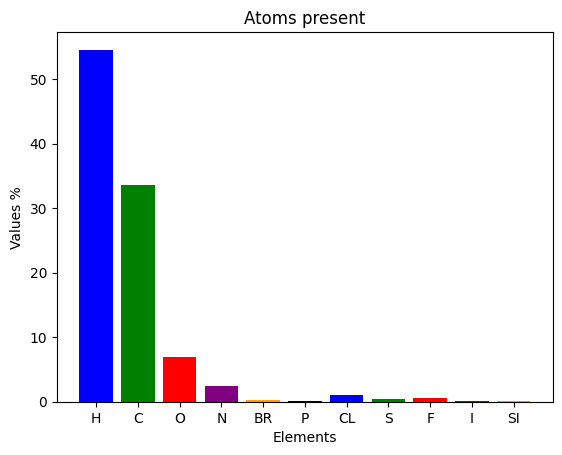

In [ ]:
#Code used to obtain SMILE strings for each of the solute and solvent molecules using an api and pubchempy package.
#The obtained results are cleaned and saved as a csv file which is later used for training and testing purposes.

# dir and function to load raw data
raw_data_dir = '/content/CIGIN_CS598_data/data/'
raw_data = pd.read_csv(raw_data_dir+'MNSol_Acquired_Dataset.csv', sep=";")

filtered = []

df = pd.read_csv(raw_data_dir+'alldata.csv')

element_dict = {}

def parse_atoms(atom_string, ans_dict):
    if len(atom_string) == 0:
        return ans_dict

    char_start = 0
    element = ''

    rep = ''

    while char_start < len(atom_string) and atom_string[char_start].isalpha():
        element += atom_string[char_start]
        char_start += 1

    while char_start < len(atom_string) and not atom_string[char_start].isalpha():
        rep += atom_string[char_start]
        char_start += 1

    if element in ans_dict:
        ans_dict[element] += int(rep)
    else:
        ans_dict[element] = int(rep)

    return parse_atoms(atom_string[char_start:], ans_dict)

df = pd.read_csv(raw_data_dir+'alldata.csv')
for index, row in df.iterrows():
    formula = row["Formula"]
    parse_atoms(formula, element_dict)
percent_dict = {key: (value / sum(element_dict.values())) * 100 for key, value in element_dict.items()}

labels = list(element_dict.keys())
values = list(percent_dict.values())

colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']

plt.bar(labels, values, color=colors)

plt.title('Atoms present')
plt.xlabel('Elements')
plt.ylabel('Values %')
plt.show()


# Commenting the code below as data is acquired and stored in the drive as part of preprocessing step!

# for index, row in df.iterrows():
#     charge_value = row["Charge"]
#     type_ = row["type"]

#     if charge_value != 0 or type_ != 'abs':
#         continue

#     filtered.append({'Solute': row['SoluteName'], 'Solvent': row['Solvent'], 'DeltaGsolv': row['DeltaGsolv']})

# print(f'total samples: {len(filtered)}')

# def CIRconvert(ids):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return 'Did not work'

# def get_smile(compound_name):
#     results = pcp.get_compounds(compound_name, 'name')
#     if len(results) == 1:
#         compund = pcp.Compound.from_cid(results[0].cid)
#         return compund.isomeric_smiles

#     else:
#         return CIRconvert(compound_name)

# from urllib.request import urlopen
# from urllib.parse import quote
# from tqdm import tqdm
# import time

# i = 1

# for idx in tqdm(range(len(filtered))):
#     i += 1
#     filtered[idx]['SoluteSmiles'] = get_smile(filtered[idx]['Solute'])
#     filtered[idx]['SolventSmiles'] = get_smile(filtered[idx]['Solvent'])
#     time.sleep(1)

#     if i % 900 == 0:
#         time.sleep(600)

# counter = 0
# pure = []
# for element in filtered:
#     add = True
#     for key, value in element.items():
#         if type(value) == str and 'work' in value:
#             counter += 1
#             add = False
#             break
#     if add:
#         pure.append(element)

# df = pd.DataFrame(pure)

# Save the DataFrame to a CSV file
# df.to_csv('cleaned_data.csv', index=False)






The above figure shows the presence of elements in the solute and solvent molecules. The high percentage of hydrogen justifies why the authors and we have not considered Hydrogen atoms while forming molecule graphs.

Dataset Size: 2328


Top 5 most frequently used solutes:
      Solute  Count_of_samples
     ethanol                62
     toluene                59
  2-butanone                57
    n-octane                51
nitromethane                50


Most used solvent: water




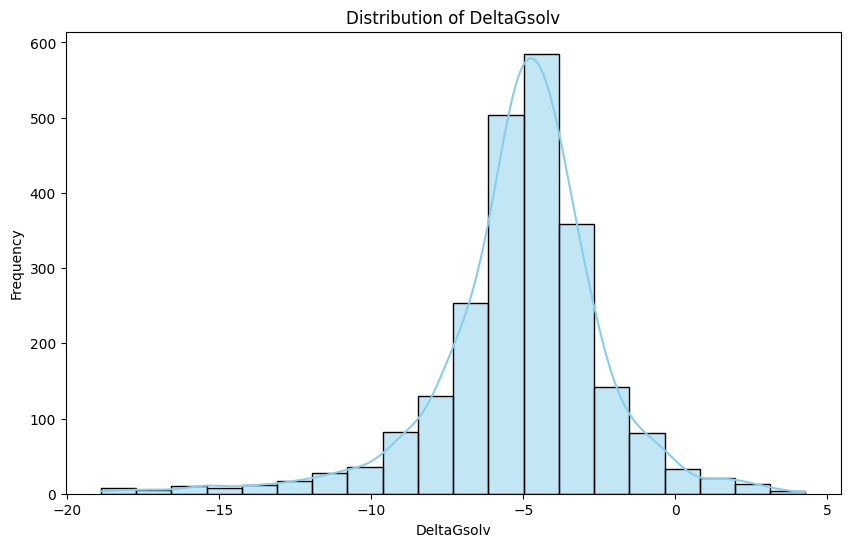

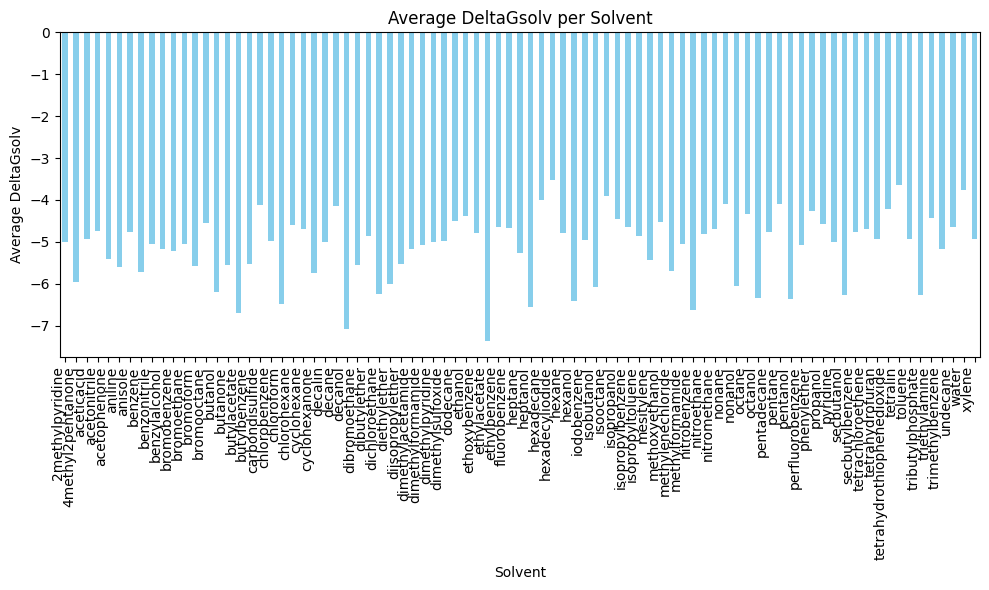

In [ ]:
# calculating statistics
def calculate_stats(raw_data):
  sample_size = len(raw_data)
  print("Dataset Size:", sample_size)
  print("\n")
  top_solute_frequency = raw_data['Solute'].value_counts().sort_values(ascending=False).head(5)
  top_solute_frequency = top_solute_frequency.rename_axis('Solute').reset_index(name='Count_of_samples')
  print("Top 5 most frequently used solutes:")
  print(top_solute_frequency.to_string(index=False))
  print("\n")

  # Finding the most used solvent
  most_used_solvent = raw_data['Solvent'].mode()[0]
  print("Most used solvent:", most_used_solvent)
  print("\n")

  # DeltaGsolv Distribution
  plt.figure(figsize=(10, 6))
  sns.histplot(raw_data['DeltaGsolv'], kde=True, color='skyblue', bins=20)
  plt.title('Distribution of DeltaGsolv')
  plt.xlabel('DeltaGsolv')
  plt.ylabel('Frequency')
  plt.show()
  print("\n")
  # Calculating the average DeltaGsolv per solvent
  avg_delta_per_solute = raw_data.groupby('Solvent')['DeltaGsolv'].mean()

  # Ploting the average DeltaGsolv per solvent
  plt.figure(figsize=(10, 6))
  avg_delta_per_solute.plot(kind='bar', color='skyblue')
  plt.title('Average DeltaGsolv per Solvent')
  plt.xlabel('Solvent')
  plt.ylabel('Average DeltaGsolv')
  plt.xticks(rotation=90, ha='right')
  plt.tight_layout()
  plt.show()
  print("\n")

calculate_stats(raw_data)

In [ ]:
# Spliting the data into features (X) and target variable (y)
X = raw_data.drop(columns=['DeltaGsolv'])  # Features
y = raw_data['DeltaGsolv']  # Target variable

# Spliting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Saving the train, validation, and test sets to CSV files
train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

#Commenting the below lines of code as cleaned and split data is already stored in the drive!

# train_data.to_csv(raw_data_dir+'train_data.csv', index=False)
# valid_data.to_csv(raw_data_dir+'validation_data.csv', index=False)
# test_data.to_csv(raw_data_dir+'test_data.csv', index=False)

Solute :  2-hexanone


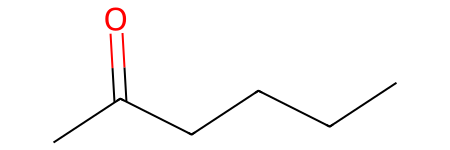

In [ ]:
train_df = pd.read_csv(raw_data_dir+'train_data.csv')
valid_df = pd.read_csv(raw_data_dir+'validation_data.csv')
test_df = pd.read_csv(raw_data_dir+'test_data.csv')

random_sample = train_df.sample(n=1, random_state=42)
SoluteSMILES = random_sample['SoluteSMILES'].iloc[0]
SolventSMILES = random_sample['SolventSMILES'].iloc[0]
print("Solute : ", random_sample['Solute'].iloc[0])
Chem.MolFromSmiles(SoluteSMILES)



Solvent :  perfluorobenzene


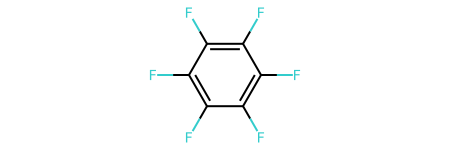

In [ ]:
print("Solvent : ", random_sample['Solvent'].iloc[0])
Chem.MolFromSmiles(SolventSMILES)

## EXPERIMENT 1 TO TEST THE MAIN HYPOTHESIS



### MODEL

<b>Citation to the original paper : </b> Pathak, Y., Laghuvarapu, S., Mehta, S., & Priyakumar, U. D. (2020). Chemically Interpretable Graph Interaction Network for Prediction of Pharmacokinetic Properties of Drug-Like Molecules. Proceedings of the AAAI Conference on Artificial Intelligence, 34(01), 873-880. https://doi.org/10.1609/aaai.v34i01.5433

<b> Link to the original paper’s repo : </b> https://github.com/devalab/CIGIN

<b> Model descriptions : </b>

<b> MODEL ARCHITECTURE </b>
Our model consists of two model architectures, joined together.
  * MessagePassing: A message passing neural network (MPNN) based on the paper "Neural Message Passing for Quantum Chemistry." It consists solely of linear transformations.
  * Cigin: Combines two instances of the MessagePassing layer for solute and solvent molecules, followed by interaction and prediction phases. It uses Set2Set pooling to aggregate node features and linear layers for prediction.

Here's a tabular structure explaining the input-output dimensions for each layer in the provided models:

| Layer              | Input Dimensions                         | Output Dimensions                        |
|--------------------|------------------------------------------|------------------------------------------|
| `MessagePassing`      | Node feature: (B1, D1)<br>Edge feature: (B2, D2) <br>Timesteps: (1)| Node feature: (B1, D1)<br> <br>Edge feature: (B2, D2) |
| `Linear` (U_0)    | Node feature: (B1, D1)                   | Node feature: (B1, D_1)      |
| `Linear` (U_1) | Node feature: (B1, 2 * D1 + D2) | Node feature: (B1, D1)      |
| `Linear` (U_2)    | Node feature: (B1, 2 * D1 + D2)                   | Node feature: (B1, D1)      |
| `Linear` (M_0) | Node feature: (B1, 2 * D1) | Node feature: (B1, D1)      |
| `Linear` (M_1)    | Node feature: (B1, 2 * D1)                   | Node feature: (B1, D1)      |
| `Linear` (M_2) | Node feature: (B1, 2 * D1) | Node feature: (B1, D1)      |
| `CIGINModel`       | Node feature: (B1, D1)<br>Edge feature: (B2, D2) <br> Timesteps: (1) | Node feature: (B1, D1)<br> |
| `Linear` (first_layer)     | Node feature: (B1, 16 * D1)  | Node feature: (B1, 360)                  |
| `Linear` (second_layer)     | Node feature: (B1, 360)                  | Node feature: (B1, 200)                  |
| `Linear` (third_layer)     | Node feature: (B1, 200)                  | Node feature: (B1, 120)                    |
| `Linear` (fourth_layer)    | Node feature: (B1, 120)               | Node feature: (B1, 1)                 |
| `Set2Set` (set2set_input_solute, set2set_input_solvent)    | Node feature: (B1, 2, D1)               | Node feature: (B1, 2*D1)                 |
| `Set2Set` (combined_features_solute_features, combined_features_solvent_features)    | Node feature: (B1, D1)               | Pooled node feature: (2*D1)                 |
| `LSTM` (lstm_solute, lstm_solvent) | Node feature: (B1, 2 * D1) | Set feature: (B1, D1)  |
| `LSTM` (lstm_gather_solute, lstm_gather_solvent) | Node feature: (B1, 8 * D1) | Set feature: (B1, 4 * D1) |

Where,
- **B1**: Num of nodes - **D1**: Node feature size - **B2**: Num of edges - **D2**: Edge feature size


<b> Implementation code : </b> The model implementation is provided below. This code is adapted from the the github repo mentioned above.

<b> Pre-trained model : </b> The github repo includes a pre-trained model which we have included in our github repo. We will use this pre-trained model provided by the authors to compare the performance of our model trained below.


In [ ]:
#Data reading, atomic and bond feature extraction and molecular graph construction code

def collate_Cigin(samples):
    solute, solvent, labels = map(list, zip(*samples))
    return np.array(solute, dtype=object), np.array(solvent, dtype=object), labels


class Dataclass_Cigin(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        solute = self.dataset.loc[idx]['SoluteSMILES']
        solvent = self.dataset.loc[idx]['SolventSMILES']
        delta_g = self.dataset.loc[idx]['DeltaGsolv']
        return [solute, solvent, [delta_g]]

In [ ]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

def one_of_k_encoding_Cigin(x, allowable_set):
    '''Function to get one hot encoding'''

    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk_Cigin(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''

    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))


def bond_features_Cigin(bond, use_chirality=True,bond_length=None):
    '''Bond level features from rdkit bond object'''

    bt = bond.GetBondType()
    bond_feats = [
      bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
      bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
      bond.GetIsConjugated(),
      bond.IsInRing()
    ]
    if bond_length is not None:
        bond_feats = bond_feats + [bond_length]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk_Cigin(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

def atom_features_Cigin(atom,stereo,features,bool_id_feat=False,explicit_H=False):
    '''Atom level features from rdkit's atom object '''
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        results = one_of_k_encoding_unk_Cigin(
          atom.GetSymbol(),
          [
            'C',
            'N',
            'O',
            'S',
            'F',
            'P',
            'Cl',
            'Br',
            'I',
            'Si'
          ]) + one_of_k_encoding_Cigin(atom.GetDegree(),
                                 [0, 1, 2, 3, 4]) + \
                  one_of_k_encoding_unk_Cigin(atom.GetImplicitValence(), [0, 1]) + \
                  one_of_k_encoding_unk_Cigin(atom.GetNumRadicalElectrons(), [0, 1]) + \
                  one_of_k_encoding_unk_Cigin(atom.GetFormalCharge(), [-1, 0, 1]) + \
                  one_of_k_encoding_unk_Cigin(atom.GetHybridization(), [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D]) + \
                  [int(i) for i in list("{0:06b}".format(features))]

    if not explicit_H:
          results = results + one_of_k_encoding_unk_Cigin(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])

    try:
        results = results + one_of_k_encoding_unk_Cigin(
            stereo,
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
    except Exception as e:
        results = results + [False, False
                          ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

def ConstructMolecularGraph_Cigin(molecule):

    '''Constructs molecular graph from rdkit's molecule object '''

    g = OrderedDict({})
    h = OrderedDict({})

    molecule = Chem.MolFromSmiles(molecule)
    stereo = Chem.FindMolChiralCenters(molecule)
    features = rdDesc.GetFeatureInvariants(molecule)
    chiral_centers = [0]* molecule.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]
    for i in range(0, molecule.GetNumAtoms()):
        atom_i = molecule.GetAtomWithIdx(i)
        h[i] = torch.FloatTensor(atom_features_Cigin(atom_i,chiral_centers[i],features[i]).astype(np.float64)).to(device)
        for j in range(0, molecule.GetNumAtoms()):
            e_ij = molecule.GetBondBetweenAtoms(i, j)

            if e_ij != None:
                e_ij =  map(lambda x: 1 if x == True else 0, bond_features_Cigin(e_ij).tolist()) # ADDED edge feat
                e_ij = torch.FloatTensor(list(e_ij)).to(device)
                atom_j = molecule.GetAtomWithIdx(j)
                if i not in g:
                    g[i] = []
                g[i].append( (e_ij, j) )

    return g, h

In [ ]:
#CIGIN Variant 2 implementation - Best Performing Model in Paper : (set2set layers in both the message passing and prediction phase)

device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.lstm_solute = torch.nn.LSTM(2*self.node_dim,self.node_dim)
        self.lstm_solvent = torch.nn.LSTM(2*self.node_dim,self.node_dim)

        self.lstm_gather_solute = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)
        self.lstm_gather_solvent = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)

        self.first_layer = nn.Linear(16*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.third_layer = nn.Linear(200,120)
        self.fourth_layer = nn.Linear(120,1)

    def set2set(self,tensor,no_of_features,no_of_steps,lstm):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        n = tensor.shape[0]
        tensor=tensor.transpose(0,1)
        q_star = torch.zeros(n,2*no_of_features).to(device)
        hidden = (torch.zeros(1, n, no_of_features).to(device),
              torch.zeros(1, n, no_of_features).to(device))
        for i in range(no_of_steps):
            q,hidden = lstm(q_star.unsqueeze(0),hidden)
            e = torch.sum(tensor*q,2)
            a = F.softmax(e,dim=0)
            r = a.unsqueeze(2)*tensor
            r=  torch.sum(r,0)
            q_star = torch.cat([q.squeeze(0),r],1)
        return q_star


    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph_Cigin(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        set2set_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.set2set(set2set_input_solute,self.node_dim,self.LSTM_t,self.lstm_solute) #A
        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph_Cigin(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        set2set_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.set2set(set2set_input_solvent,self.node_dim,self.LSTM_t,self.lstm_solvent) #B
        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)
        interaction_map_2 = torch.zeros(n,m)

        for i,solute_row in enumerate(gather_solute):
            for j,solvent_row in enumerate(gather_solvent):
                interaction_map[i, j] = torch.sum(torch.mul(solute_row, solvent_row))
                interaction_map_2[i, j] = torch.sum(torch.mul(solute_row, solvent_row))


        interaction_map_2 = torch.tanh(interaction_map_2) #I


        solute_after_interaction = torch.mm(interaction_map_2, gather_solvent) #A'
        solvent_after_interaction = torch.mm(interaction_map_2.t(), gather_solute) #B'

        #Prediction phase
        combined_features_solute_features = self.set2set(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features,2,self.lstm_gather_solute) #A''
        combined_features_solvent_features = self.set2set(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features,2,self.lstm_gather_solvent) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()



### TRAINING

<b> <h4> Hyperparameters : </h4></b>
<li> Loss Function: <br>
&emsp;&emsp;&emsp; Mean Squared Error (MSELoss) is used as the loss function. <br>
&emsp;&emsp;&emsp;Mean Absolute Error (L1Loss) is also calculated as a metric.
<li> Optimization: <br>
&emsp;&emsp;&emsp;Adam optimizer is used with a learning rate of 0.001.
<li> Learning Rate Scheduler:  <br>
&emsp;&emsp;&emsp;ReduceLROnPlateau scheduler is used with a patience of 5, mode set to 'min', and verbose mode enabled.
<li> Regularization: <br>
&emsp;&emsp;&emsp;L1 norm regularization is applied to the loss with a coefficient of 1e-4.
<li> Device: <br>
&emsp;&emsp;&emsp;The code checks for the availability of CUDA and assigns the device accordingly.

<b> <h4> Computational Requirements : </h4></b>
<li> Hardware : <br>
 &emsp;&emsp;&emsp;GPU-accelerated hardware is recommended for training. Specifically, hardware with NVIDIA GPUs, such as Tesla, GeForce, or Quadro series, would be suitable. We have used the default CPU for Colab with an Intel Xeon CPU with 2 vCPUs (virtual CPUs) and 13GB of RAM.
 <li> Number of Epochs: <br>
 &emsp;&emsp;&emsp;We trained the model with 50 epochs. The training and validation loss is plotted to determine the specific number of epochs required for optimal performance.
 <li> Average runtime for epoch : <br>
 &emsp;&emsp;&emsp;On average it took 2 mins 45 seconds to run an epoch.


In [ ]:
loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


def get_metrics_Cigin(model, data_loader):
    valid_outputs = []
    valid_labels = []
    valid_loss = []
    valid_mae_loss = []
    for solute, solvent, labels in tqdm(data_loader):
        outputs, i_map = model(solute[0], solvent[0])
        loss = loss_fn(outputs, torch.tensor(labels[0]).float())
        mae_loss = mae_loss_fn(outputs, torch.tensor(labels[0]).to(device).float())
        valid_outputs += outputs.cpu().detach().numpy().tolist()
        valid_loss.append(loss.cpu().detach().numpy())
        valid_mae_loss.append(mae_loss.cpu().detach().numpy())
        valid_labels += labels

    loss = np.mean(np.array(valid_loss).flatten())
    mae_loss = np.mean(np.array(valid_mae_loss).flatten())
    return loss, mae_loss


def train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader):
    best_val_loss = 100
    training_losses = []
    validation_losses = []
    for epoch in range(max_epochs):
        model.train()
        running_loss = []
        tq_loader = tqdm(train_loader)
        o = {}
        for samples in tq_loader:
            optimizer.zero_grad()
            outputs, interaction_map = model(samples[0][0], samples[1][0])
            l1_norm = torch.norm(interaction_map, p=2) * 1e-4
            loss = loss_fn(outputs, torch.tensor(samples[2][0]).float()) + l1_norm
            loss.backward()
            optimizer.step()
            loss = loss - l1_norm
            running_loss.append(loss.cpu().detach())
            tq_loader.set_description(
                "Epoch: " + str(epoch + 1) + "  Training loss: " + str(np.mean(np.array(running_loss))))
        training_losses.append(np.mean(np.array(running_loss)))
        model.eval()
        val_loss, mae_loss = get_metrics_Cigin(model, valid_loader)
        scheduler.step(val_loss)
        validation_losses.append(val_loss)
        print("Epoch: " + str(epoch + 1) + "  train_loss " + str(np.mean(np.array(running_loss))) + " Val_loss " + str(
            val_loss) + " MAE Val_loss " + str(mae_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    # Ploting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    return best_model

In [ ]:
# Commenting the below code as the model is trained separately with 50 epochs and stored in the drive!

# max_epochs = 1
# batch_size = 1

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_Cigin(train_df)
# valid_dataset = Dataclass_Cigin(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_Cigin, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_Cigin, batch_size=1)
# model = Cigin()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)

## saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_hypothesis.tar")

### EVALUATION

Loading our trained model from the drive and presenting the model performance on test dataset.

In [ ]:
loaded_model = Cigin().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_hypothesis.tar'))
loaded_model.eval()
test_dataset = Dataclass_Cigin(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_Cigin, batch_size=1)
loss, mae_loss = get_metrics_Cigin(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 233/233 [00:07<00:00, 31.29it/s]


Loss :  0.3655949 
Mean Absolute Error Loss:  0.31940457 
Root Mean Square Error:  0.6046444


In [ ]:
loaded_model_pretrained_authors = Cigin().to(device)
loaded_model_pretrained_authors.load_state_dict(torch.load(raw_data_dir+'pretrained_cigin_authors.tar'))
loaded_model.eval()
test_dataset_available = Dataclass_Cigin(test_df)
test_loader_available = DataLoader(test_dataset_available, collate_fn=collate_Cigin, batch_size=1)
reported_loss, reported_mae_loss = get_metrics_Cigin(loaded_model_pretrained_authors, test_loader_available)
print("\nLoss : ",reported_loss, "\nMean Absolute Error Loss: ", reported_mae_loss, "\nRoot Mean Square Error: ", np.sqrt(reported_loss))

100%|██████████| 233/233 [00:05<00:00, 42.18it/s]



Loss :  2.157248 
Mean Absolute Error Loss:  0.46349064 
Root Mean Square Error:  1.4687573


Below is the plot of Training and Validation Loss per Epoch.

![Model Training and Validation Loss per Epoch](https://drive.google.com/uc?export=view&id=1j1io4AIPK7-hC9YB7X3Kt3XiIY9NOcaf)


### RESULTS:

<b> METRIC USED : </b> Root Mean Square Error <br>
The root mean square error (RMSE) measures the average difference between a trained model's predicted values and the actual values. It computes the root of mean of the squared errors. <br>


The model proposed in the paper yielded a final loss of 0.3655949, mean absolute error of  0.31940457, and root mean square error of 0.6046444 on the test set. <br> See a figure of the loss of this model above. Note that both the training and validation loss slowly leveled out and became near-constant at approximately epoch 40, indicating that the model has reached close to its best possible performance. <br><br>

<h4> COMPARISON OF RESULTS </h4>

| Metric              | Results                         |
|--------------------|------------------------------------------|
| Trained model RMSE      | 0.6046444 |
| RMSE reported by the authors in the paper  | 0.57      |
| RMSE acquired by the pre-trained model available| 1.4687573   |

From the above table, we can see that our trained model's performance (0.60) is very closed to the performance reported by the authors in the paper (0.57).

### DISCUSSION

Based on the above results, we proved the hypothesis that the authors have claimed in the research paper. The original paper was reproducible with little effort as the code provided by the authors is straight forward and the proposed model's performance is reproduced by us. <br>
The easy aspect of reproducing the results or proving the hypothesis is the avialability of the dataset the authors used and necessary pre-processing steps. The code was also readily accessible. <br>
The difficult aspect of the implementation is handling different versions of rdkit and dgl packages. During package installations, we faced issues with these packages compatibility with different python,cuda versions and pytorch versions. <br>

Our initial recommendation to the authors was to improve the model training process by enabling batching. This can be achieved by keeping the data processing and model training part separate. However, the authors have recently released a version 2 of the model they proposed in the research paper with this feature included. This new version also further improved the model performance by reducing the RMSE metric. Hence, we show the implementation of this better version in the 'Experiments beyond the paper' section of this notebook. (Experiment 1 in the below section).


# EXPERIMENTS BEYOND THE PAPER:




##ADDITIONAL EXPERIMENT 1 : CIGIN Version 2

The authors of the paper have provided a better version of the above model and called it CIGIN version 2. The code for this version is provided in the source github repository, inside a separate folder named CIGIN_V2. We show the implementation of this better model below.

<b> Major differences between CIGIN and CIGIN Version 2: </b> <br>
CIGIN Version 2 enables batching as opposed to CIGIN baseline model as it performs data preprocessing within the model and takes strings as input. The below advanced version 2 preprocesses the SMILE strings separately before the model training. This model uses DGLGraph module from the DGL package to convert the SMILE strings of solute and solvent molecules into graph structure with atoms as nodes and atomic bonds as edges.

In addition, the Message Passing Neural Network structure is more complex in V2. While the original model only used linear layers during message passing, the second model adds a convolutional layer as well.

### PREPROCESSING

The following data preprocessing functions are used to extract necessary features in desired data formats to train the neural network.

In [ ]:
def collate_CiginV2(samples):
    """Collates a list of samples into a batch for processing.
    Batches solute and solvent graphs and computes length matrices.
    Returns batched graphs, length matrices, and labels."""
    solute_graphs, solvent_graphs, labels = map(list, zip(*samples))
    solute_graphs = dgl.batch(solute_graphs)
    solvent_graphs = dgl.batch(solvent_graphs)
    solute_len_matrix = get_len_matrix_CiginV2(solute_graphs.batch_num_nodes().numpy())
    solvent_len_matrix = get_len_matrix_CiginV2(solvent_graphs.batch_num_nodes().numpy())
    return solute_graphs, solvent_graphs, solute_len_matrix, solvent_len_matrix, labels


class Dataclass_CiginV2(Dataset):
    """Custom dataset class for processing input data.
      Processes SMILES strings into molecular graphs.
    Returns samples containing solute, solvent graphs, and labels."""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        solute = self.dataset.loc[idx]['SoluteSMILES']
        mol = Chem.MolFromSmiles(solute)
        mol = Chem.AddHs(mol)
        solute = Chem.MolToSmiles(mol)
        solute_graph = get_graph_from_smile_CiginV2(solute)

        solvent = self.dataset.loc[idx]['SolventSMILES']
        mol = Chem.MolFromSmiles(solvent)
        mol = Chem.AddHs(mol)
        solvent = Chem.MolToSmiles(mol)

        solvent_graph = get_graph_from_smile_CiginV2(solvent)
        delta_g = self.dataset.loc[idx]['DeltaGsolv']
        return [solute_graph, solvent_graph, [delta_g]]

def one_of_k_encoding_CiginV2(x, allowable_set):
    """Encodes categorical variable `x` into a one-hot vector.
        Handles values not in the allowable set."""
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk_CiginV2(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]

    return list(map(lambda s: x == s, allowable_set))


def get_len_matrix_CiginV2(len_list):
    """Generates a length matrix from a list of lengths.
        Indicates the presence of nodes in graphs."""
    len_list = np.array(len_list)
    max_nodes = np.sum(len_list)
    curr_sum = 0
    len_matrix = []
    for l in len_list:
        curr = np.zeros(max_nodes)
        curr[curr_sum:curr_sum + l] = 1
        len_matrix.append(curr)
        curr_sum += l
    return np.array(len_matrix)

def get_atom_features_CiginV2(atom, stereo, features, explicit_H=False):
    """
    Method that computes atom level features from rdkit atom object
    :param atom:
    :param stereo:
    :param features:
    :param explicit_H:
    :return: the node features of an atom
    """
    possible_atoms = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'Si']
    atom_features = one_of_k_encoding_unk_CiginV2(atom.GetSymbol(), possible_atoms)
    atom_features += one_of_k_encoding_unk_CiginV2(atom.GetImplicitValence(), [0, 1])
    atom_features += one_of_k_encoding_unk_CiginV2(atom.GetNumRadicalElectrons(), [0, 1])
    atom_features += one_of_k_encoding_CiginV2(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6])
    atom_features += one_of_k_encoding_unk_CiginV2(atom.GetFormalCharge(), [-1, 0, 1])
    atom_features += one_of_k_encoding_unk_CiginV2(atom.GetHybridization(), [
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D])
    atom_features += [int(i) for i in list("{0:06b}".format(features))]

    if not explicit_H:
        atom_features += one_of_k_encoding_unk_CiginV2(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

    try:
        atom_features += one_of_k_encoding_unk_CiginV2(stereo, ['R', 'S'])
        atom_features += [atom.HasProp('_ChiralityPossible')]
    except Exception as e:

        atom_features += [False, False
                          ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(atom_features)


def get_bond_features_CiginV2(bond):
    """
    Method that computes bond level features from rdkit bond object
    :param bond: rdkit bond object
    :return: bond features, 1d numpy array
    """

    bond_type = bond.GetBondType()
    bond_feats = [
        bond_type == Chem.rdchem.BondType.SINGLE, bond_type == Chem.rdchem.BondType.DOUBLE,
        bond_type == Chem.rdchem.BondType.TRIPLE, bond_type == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    bond_feats += one_of_k_encoding_unk_CiginV2(str(bond.GetStereo()), ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])

    return np.array(bond_feats)


def get_graph_from_smile_CiginV2(molecule_smile):
    """
    Method that constructs a molecular graph with nodes being the atoms
    and bonds being the edges.
    :param molecule_smile: SMILE sequence
    :return: DGL graph object, Node features and Edge features
    """

    G = DGLGraph()
    molecule = Chem.MolFromSmiles(molecule_smile)
    features = rdDesc.GetFeatureInvariants(molecule)

    stereo = Chem.FindMolChiralCenters(molecule)
    chiral_centers = [0] * molecule.GetNumAtoms()
    for i in stereo:
        chiral_centers[i[0]] = i[1]

    G.add_nodes(molecule.GetNumAtoms())
    node_features = []
    edge_features = []
    for i in range(molecule.GetNumAtoms()):

        atom_i = molecule.GetAtomWithIdx(i)
        atom_i_features = get_atom_features_CiginV2(atom_i, chiral_centers[i], features[i])
        node_features.append(atom_i_features)

        for j in range(molecule.GetNumAtoms()):
            bond_ij = molecule.GetBondBetweenAtoms(i, j)
            if bond_ij is not None:
                G.add_edges(i, j)
                bond_features_ij = get_bond_features_CiginV2(bond_ij)
                edge_features.append(bond_features_ij)

    G.ndata['x'] = torch.from_numpy(np.array(node_features))
    G.edata['w'] = torch.from_numpy(np.array(edge_features))

    return G


###   MODEL

<b> MODEL ARCHITECTURE </b>
  * GatherModel: A message passing neural network (MPNN) based on the paper "Neural Message Passing for Quantum Chemistry." It consists of multiple message passing steps using NNConv layers and linear transformations.
  * CIGINModel: Combines two instances of the GatherModel for solute and solvent molecules, followed by interaction and prediction phases. It uses Set2Set pooling to aggregate node features and linear layers for prediction.

Here's a tabular structure explaining the input-output dimensions for each layer in the provided models:

| Layer              | Input Dimensions                         | Output Dimensions                        |
|--------------------|------------------------------------------|------------------------------------------|
| `GatherModel`      | Node feature: (B1, D1)<br>Edge feature: (B2, D2) | Node feature: (B1, D1)<br> |
| `Linear` (lin0)    | Node feature: (B1, D1)                   | Node feature: (B1, node_hidden_dim)      |
| `Set2Set` (set2set)| Node feature: (B1, node_hidden_dim)      | Set feature: (B1, 2 * node_hidden_dim)   |
| `Linear` (message_layer) | Node feature: (B1, 2 * node_hidden_dim) | Node feature: (B1, node_hidden_dim)      |
| `NNConv` (conv)    | Node feature: (B1, node_hidden_dim)      | Node feature: (B1, node_hidden_dim)      |
| `CIGINModel`       | Node feature: (B1, D1)<br>Edge feature: (B2, D2) | Node feature: (B1, D1)<br> |
| `Linear` (fc1)     | Node feature: (B1, 8 * node_hidden_dim)  | Node feature: (B1, 256)                  |
| `Linear` (fc2)     | Node feature: (B1, 256)                  | Node feature: (B1, 128)                  |
| `Linear` (fc3)     | Node feature: (B1, 128)                  | Node feature: (B1, 1)                    |
| `Linear` (imap)    | Interaction map: (B1, 80)               | Interaction map: (B1, 1)                 |
| `Set2Set` (set2set_solute, set2set_solvent) | Node feature: (B1, 2 * node_hidden_dim) | Set feature: (B1, 2 * node_hidden_dim)  |
| `torch.cat`        | Node features: (B1, 4 * node_hidden_dim) | Node features: (B1, 8 * node_hidden_dim) |
| `torch.relu`       | Node features: (B1, 8 * node_hidden_dim) | Node features: (B1, 8 * node_hidden_dim) |
| `torch.relu`       | Node features: (B1, 256)                 | Node features: (B1, 256)                 |
| `torch.relu`       | Node features: (B1, 128)                 | Node features: (B1, 128)                 |
| `CIGINModel`       | Node features: (B1, 256)                 | Predictions: (B1, 1)                     |

Where,
- **B1**: Num of nodes - **D1**: Node feature size - **B2**: Num of edges - **D2**: Edge feature size


In [ ]:
class GatherModel(nn.Module):
    """
    MPNN from
    `Neural Message Passing for Quantum Chemistry <https://arxiv.org/abs/1704.01212>`
    Parameters
    ----------
    node_input_dim : int
        Dimension of input node feature, default to be 42.
    edge_input_dim : int
        Dimension of input edge feature, default to be 10.
    node_hidden_dim : int
        Dimension of node feature in hidden layers, default to be 42.
    edge_hidden_dim : int
        Dimension of edge feature in hidden layers, default to be 128.
    num_step_message_passing : int
        Number of message passing steps, default to be 6.
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 ):
        super(GatherModel, self).__init__()
        self.num_step_message_passing = num_step_message_passing
        self.lin0 = nn.Linear(node_input_dim, node_hidden_dim)
        self.set2set = Set2Set(node_hidden_dim, 2, 1)
        self.message_layer = nn.Linear(2 * node_hidden_dim, node_hidden_dim)
        edge_network = nn.Sequential(
            nn.Linear(edge_input_dim, edge_hidden_dim), nn.ReLU(),
            nn.Linear(edge_hidden_dim, node_hidden_dim * node_hidden_dim))
        self.conv = NNConv(in_feats=node_hidden_dim,
                           out_feats=node_hidden_dim,
                           edge_func=edge_network,
                           aggregator_type='sum',
                           residual=True
                           )

    def forward(self, g, n_feat, e_feat):
        """Returns the node embeddings after message passing phase.
        Parameters
        ----------
        g : DGLGraph
            Input DGLGraph for molecule(s)
        n_feat : tensor of dtype float32 and shape (B1, D1)
            Node features. B1 for number of nodes and D1 for
            the node feature size.
        e_feat : tensor of dtype float32 and shape (B2, D2)
            Edge features. B2 for number of edges and D2 for
            the edge feature size.
        Returns
        -------
        res : node features
        """

        init = n_feat.clone()
        out = F.relu(self.lin0(n_feat))
        for i in range(self.num_step_message_passing):
            if e_feat is not None:
                m = torch.relu(self.conv(g, out, e_feat))
            else:
                m = torch.relu(self.conv.bias +  self.conv.res_fc(out))
            out = self.message_layer(torch.cat([m, out], dim=1))
        return out + init


class CIGINModel(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 interaction='dot',
                 num_step_set2_set=2,
                 num_layer_set2set=1,
                 ):
        super(CIGINModel, self).__init__()

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction
        self.solute_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                         self.node_hidden_dim, self.edge_input_dim,
                                         self.num_step_message_passing,
                                         )
        self.solvent_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                          self.node_hidden_dim, self.edge_input_dim,
                                          self.num_step_message_passing,
                                          )

        self.fc1 = nn.Linear(8 * self.node_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.imap = nn.Linear(80, 1) #keep unchanged

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set_solute = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)
        self.set2set_solvent = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

    def forward(self, data):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.solute_gather(solute, solute.ndata['x'].float(), solute.edata['w'].float())
        try:
            # if edge exists in a molecule
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), solvent.edata['w'].float())
        except:
            # if edge doesn't exist in a molecule, for example in case of water
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), None)

        # Interaction phase
        len_map = torch.mm(solute_len.t(), solvent_len)

        if 'dot' not in self.interaction:
            X1 = solute_features.unsqueeze(0)
            Y1 = solvent_features.unsqueeze(1)
            X2 = X1.repeat(solvent_features.shape[0], 1, 1)
            Y2 = Y1.repeat(1, solute_features.shape[0], 1)
            Z = torch.cat([X2, Y2], -1)

            if self.interaction == 'general':
                interaction_map = self.imap(Z).squeeze(2)
            if self.interaction == 'tanh-general':
                interaction_map = torch.tanh(self.imap(Z)).squeeze(2)

            interaction_map = torch.mul(len_map.float(), interaction_map.t())
            ret_interaction_map = torch.clone(interaction_map)

        elif 'dot' in self.interaction:
            interaction_map = torch.mm(solute_features, solvent_features.t())
            if 'scaled' in self.interaction:
                interaction_map = interaction_map / (np.sqrt(self.node_hidden_dim))

            ret_interaction_map = torch.clone(interaction_map)
            ret_interaction_map = torch.mul(len_map.float(), ret_interaction_map)
            interaction_map = torch.tanh(interaction_map)
            interaction_map = torch.mul(len_map.float(), interaction_map)

        solvent_prime = torch.mm(interaction_map.t(), solute_features)
        solute_prime = torch.mm(interaction_map, solvent_features)

        # Prediction phase
        solute_features = torch.cat((solute_features, solute_prime), dim=1)
        solvent_features = torch.cat((solvent_features, solvent_prime), dim=1)

        solute_features = self.set2set_solute(solute, solute_features)
        solvent_features = self.set2set_solvent(solvent, solvent_features)

        final_features = torch.cat((solute_features, solvent_features), 1)
        predictions = torch.relu(self.fc1(final_features))
        predictions = torch.relu(self.fc2(predictions))
        predictions = self.fc3(predictions)

        return predictions, ret_interaction_map


### TRAINING
<b>OBJECTIVES</b>:
  * loss function : Mean Squared Error (MSE) loss (torch.nn.MSELoss()) and Mean Absolute Error (MAE) loss (torch.nn.L1Loss()).
  * Optimizer : Adam optimizer (torch.optim.Adam).
  * Learning Rate Scheduler: ReduceLROnPlateau scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau) with a patience of 5 epochs and minimizing mode.


In [ ]:
loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")

def get_metrics_CiginV2(model, data_loader):
    valid_outputs = []
    valid_labels = []
    valid_loss = []
    valid_mae_loss = []
    for solute_graphs, solvent_graphs, solute_lens, solvent_lens, labels in tqdm(data_loader):
        outputs, i_map = model(
            [solute_graphs.to(device), solvent_graphs.to(device), torch.tensor(solute_lens).to(device),
             torch.tensor(solvent_lens).to(device)])
        loss = loss_fn(outputs, torch.tensor(labels).to(device).float())
        mae_loss = mae_loss_fn(outputs, torch.tensor(labels).to(device).float())
        valid_outputs += outputs.cpu().detach().numpy().tolist()
        valid_loss.append(loss.cpu().detach().numpy())
        valid_mae_loss.append(mae_loss.cpu().detach().numpy())
        valid_labels += labels

    loss = np.mean(np.array(valid_loss).flatten())
    mae_loss = np.mean(np.array(valid_mae_loss).flatten())
    return loss, mae_loss


def train_CiginV2(max_epochs, model, optimizer, scheduler, train_loader, valid_loader):
    best_val_loss = 100
    training_losses = []
    validation_losses = []
    for epoch in range(max_epochs):
        model.train()
        running_loss = []
        tq_loader = tqdm(train_loader)
        o = {}
        for samples in tq_loader:
            optimizer.zero_grad()
            outputs, interaction_map = model(
                [samples[0].to(device), samples[1].to(device), torch.tensor(samples[2]).to(device),
                 torch.tensor(samples[3]).to(device)])
            l1_norm = torch.norm(interaction_map, p=2) * 1e-4
            loss = loss_fn(outputs, torch.tensor(samples[4]).to(device).float()) + l1_norm
            loss.backward()
            optimizer.step()
            loss = loss - l1_norm
            running_loss.append(loss.cpu().detach())
            tq_loader.set_description(
                "Epoch: " + str(epoch + 1) + "  Training loss: " + str(np.mean(np.array(running_loss))))
        training_losses.append(np.mean(np.array(running_loss)))
        model.eval()
        val_loss, mae_loss = get_metrics_CiginV2(model, valid_loader)
        scheduler.step(val_loss)
        validation_losses.append(val_loss)
        print("Epoch: " + str(epoch + 1) + "  train_loss " + str(np.mean(np.array(running_loss))) + " Val_loss " + str(
            val_loss) + " MAE Val_loss " + str(mae_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    return best_model

In [ ]:
# #Commenting the below code as model is trained separately with 100 epochs and stored in the drive!

#takes an hour.

# interaction = 'dot'
# max_epochs = 100
# batch_size = 32

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_CiginV2(train_df)
# valid_dataset = Dataclass_CiginV2(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_CiginV2, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_CiginV2, batch_size=128)
# model = CIGINModel(interaction=interaction)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_CiginV2(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


## saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_additional1.tar")

### RESULTS OF ADDITIONAL EXPERIMENT 1

In [ ]:
loaded_model = CIGINModel().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_additional1.tar'))
loaded_model.eval()
test_dataset = Dataclass_CiginV2(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_CiginV2, batch_size=128)
loss, mae_loss = get_metrics_CiginV2(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Loss :  0.27065986 
Mean Absolute Error Loss:  0.30852127 
Root Mean Square Error:  0.5202498


The CIGIN Version 2 model resulted in a RMSE of 0.52 kcal/mol. This is lower than the RMSE we got using the variant 2 of the Baseline CIGIN model, proposed in the research paper (RMSE 0.60 kcal/mol). This RMSE 0.52 kcal/mol is lower than the reported RMSE of 0.57 kcal/mol, for the variant 2 of baseline CIGIN model.

### DISCUSSION

The above experimentation shows that the version 2 of the CIGIN model performs better than the model proposed by the authors in the research paper. This version 2 proposed by the authors, though not part of the published work, is a necessary advancement for the baseline model, specifically to further improve the model training time. Version 2 enables batched training, significantly reducing the model training time, while also reducing the model's error metric.

##ADDITIONAL EXPERIMENT 2 : Variant 1 of CIGIN

The authors of the paper have reported that variant 2 of baseline CIGIN (our main experiment) gave the best results. In this experiment we test the variant 1 of CIGIN model with sum pooling layers in the prediction phase instead of the set2set layers as the variant 2 of the CIGIN model. But, we test this variant 1 on the version 2 of CIGIN (Model from Additional Experiment 1 above).

As the authors stated in the paper, this model's performance is slightly less compared to the variant 2.



In [ ]:
from  dgl.nn.pytorch import SumPooling
class GatherModel(nn.Module):
    """
    MPNN from
    `Neural Message Passing for Quantum Chemistry <https://arxiv.org/abs/1704.01212>`
    Parameters
    ----------
    node_input_dim : int
        Dimension of input node feature, default to be 42.
    edge_input_dim : int
        Dimension of input edge feature, default to be 10.
    node_hidden_dim : int
        Dimension of node feature in hidden layers, default to be 42.
    edge_hidden_dim : int
        Dimension of edge feature in hidden layers, default to be 128.
    num_step_message_passing : int
        Number of message passing steps, default to be 6.
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 ):
        super(GatherModel, self).__init__()
        self.num_step_message_passing = num_step_message_passing
        self.lin0 = nn.Linear(node_input_dim, node_hidden_dim)
        self.sumpooling = SumPooling()
        self.message_layer = nn.Linear(2 * node_hidden_dim, node_hidden_dim)
        edge_network = nn.Sequential(
            nn.Linear(edge_input_dim, edge_hidden_dim), nn.ReLU(),
            nn.Linear(edge_hidden_dim, node_hidden_dim * node_hidden_dim))
        self.conv = NNConv(in_feats=node_hidden_dim,
                           out_feats=node_hidden_dim,
                           edge_func=edge_network,
                           aggregator_type='sum',
                           residual=True
                           )

    def forward(self, g, n_feat, e_feat):
        """Returns the node embeddings after message passing phase.
        Parameters
        ----------
        g : DGLGraph
            Input DGLGraph for molecule(s)
        n_feat : tensor of dtype float32 and shape (B1, D1)
            Node features. B1 for number of nodes and D1 for
            the node feature size.
        e_feat : tensor of dtype float32 and shape (B2, D2)
            Edge features. B2 for number of edges and D2 for
            the edge feature size.
        Returns
        -------
        res : node features
        """

        init = n_feat.clone()
        out = F.relu(self.lin0(n_feat))
        for i in range(self.num_step_message_passing):
            if e_feat is not None:
                m = torch.relu(self.conv(g, out, e_feat))
            else:
                m = torch.relu(self.conv.bias +  self.conv.res_fc(out))
            out = self.message_layer(torch.cat([m, out], dim=1))
        return out + init


class CIGINModel(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 interaction='dot',
                 num_step_set2_set=2,
                 num_layer_set2set=1,
                 ):
        super(CIGINModel, self).__init__()

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction
        self.solute_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                         self.node_hidden_dim, self.edge_input_dim,
                                         self.num_step_message_passing,
                                         )
        self.solvent_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                          self.node_hidden_dim, self.edge_input_dim,
                                          self.num_step_message_passing,
                                          )

        self.fc1 = nn.Linear(4 * self.node_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.imap = nn.Linear(80, 1) #keep unchanged
        self.sumpooling_solute = SumPooling()
        self.sumpooling_solvent = SumPooling()

    def forward(self, data):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.solute_gather(solute, solute.ndata['x'].float(), solute.edata['w'].float())
        try:
            # if edge exists in a molecule
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), solvent.edata['w'].float())
        except:
            # if edge doesn't exist in a molecule, for example in case of water
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), None)

        # Interaction phase
        len_map = torch.mm(solute_len.t(), solvent_len)

        if 'dot' not in self.interaction:
            X1 = solute_features.unsqueeze(0)
            Y1 = solvent_features.unsqueeze(1)
            X2 = X1.repeat(solvent_features.shape[0], 1, 1)
            Y2 = Y1.repeat(1, solute_features.shape[0], 1)
            Z = torch.cat([X2, Y2], -1)

            if self.interaction == 'general':
                interaction_map = self.imap(Z).squeeze(2)
            if self.interaction == 'tanh-general':
                interaction_map = torch.tanh(self.imap(Z)).squeeze(2)

            interaction_map = torch.mul(len_map.float(), interaction_map.t())
            ret_interaction_map = torch.clone(interaction_map)

        elif 'dot' in self.interaction:
            interaction_map = torch.mm(solute_features, solvent_features.t())
            if 'scaled' in self.interaction:
                interaction_map = interaction_map / (np.sqrt(self.node_hidden_dim))

            ret_interaction_map = torch.clone(interaction_map)
            ret_interaction_map = torch.mul(len_map.float(), ret_interaction_map)
            interaction_map = torch.tanh(interaction_map)
            interaction_map = torch.mul(len_map.float(), interaction_map)

        solvent_prime = torch.mm(interaction_map.t(), solute_features)
        solute_prime = torch.mm(interaction_map, solvent_features)

        # Prediction phase
        solute_features = torch.cat((solute_features, solute_prime), dim=1)
        solvent_features = torch.cat((solvent_features, solvent_prime), dim=1)
        solute_features = self.sumpooling_solute(solute, solute_features)

        solvent_features = self.sumpooling_solvent(solvent, solvent_features)
        final_features = torch.cat((solute_features, solvent_features), 1)
        predictions = torch.relu(self.fc1(final_features))
        predictions = torch.relu(self.fc2(predictions))
        predictions = self.fc3(predictions)

        return predictions, ret_interaction_map


In [ ]:
interaction = 'dot'
# max_epochs = 50
# batch_size = 32

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_CiginV2(train_df)
# valid_dataset = Dataclass_CiginV2(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_CiginV2, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_CiginV2, batch_size=128)
# model = CIGINModel(interaction=interaction)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_CiginV2(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


## saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_additional_sumpool.tar")

Below is the plot of Training and Validation Loss per Epoch.

![Model Training and Validation Loss per Epoch](https://drive.google.com/uc?export=view&id=18tQfQSRk9Lalz1xlQC4Ctq_INIELTKjY)



### RESULTS

In [ ]:
loaded_model = CIGINModel().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_additional_sumpool.tar'))
loaded_model.eval()
test_dataset = Dataclass_CiginV2(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_CiginV2, batch_size=128)
loss, mae_loss = get_metrics_CiginV2(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


Loss :  0.34011197 
Mean Absolute Error Loss:  0.37956932 
Root Mean Square Error:  0.5831912


The above model of additional experiment 2 resulted in a RMSE of 0.5831 Kcal/mol, which was worse than the set2set version of the model.

### DISCUSSION

Sum pooling is a more naive way of combining features across nodes, not allowing for any adjustment based on the nature of the atoms, edges, or features themselves. As such, it makes sense that a model using sum pooling would perform worse than the set2set version of the model.

## ADDITIONAL EXPERIMENT 3 - Removal and Addition of FC layers in CIGIN Version 2
In this section we change fully connected layers of the CIGIN Version 2 model, to see how it affects the performance. We conducted two experiments here: First we remove a fully connected layer and then we add an extra one.
Note that CIGIN version 2 is not part of the published research paper. It was later added to the git repository by the authors as a modification to the published work. We presented CIGIN version 2 in the Experiment 1 of `Experiments Beyond the Paper` Section (above).


### Additional Experiment 3.1 : REMOVING A FC LAYER </h3>

In [ ]:
class CIGINModel_add31(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 interaction='dot',
                 num_step_set2_set=2,
                 num_layer_set2set=1,
                 ):
        super(CIGINModel_add31, self).__init__()

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction
        self.solute_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                         self.node_hidden_dim, self.edge_input_dim,
                                         self.num_step_message_passing,
                                         )
        self.solvent_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                          self.node_hidden_dim, self.edge_input_dim,
                                          self.num_step_message_passing,
                                          )

        self.fc1 = nn.Linear(8 * self.node_hidden_dim, 256)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(256, 1)
        self.imap = nn.Linear(80, 1) #keep unchanged

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set_solute = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)
        self.set2set_solvent = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

    def forward(self, data):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.solute_gather(solute, solute.ndata['x'].float(), solute.edata['w'].float())
        try:
            # if edge exists in a molecule
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), solvent.edata['w'].float())
        except:
            # if edge doesn't exist in a molecule, for example in case of water
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), None)

        # Interaction phase
        len_map = torch.mm(solute_len.t(), solvent_len)

        if 'dot' not in self.interaction:
            X1 = solute_features.unsqueeze(0)
            Y1 = solvent_features.unsqueeze(1)
            X2 = X1.repeat(solvent_features.shape[0], 1, 1)
            Y2 = Y1.repeat(1, solute_features.shape[0], 1)
            Z = torch.cat([X2, Y2], -1)

            if self.interaction == 'general':
                interaction_map = self.imap(Z).squeeze(2)
            if self.interaction == 'tanh-general':
                interaction_map = torch.tanh(self.imap(Z)).squeeze(2)

            interaction_map = torch.mul(len_map.float(), interaction_map.t())
            ret_interaction_map = torch.clone(interaction_map)

        elif 'dot' in self.interaction:
            interaction_map = torch.mm(solute_features, solvent_features.t())
            if 'scaled' in self.interaction:
                interaction_map = interaction_map / (np.sqrt(self.node_hidden_dim))

            ret_interaction_map = torch.clone(interaction_map)
            ret_interaction_map = torch.mul(len_map.float(), ret_interaction_map)
            interaction_map = torch.tanh(interaction_map)
            interaction_map = torch.mul(len_map.float(), interaction_map)

        solvent_prime = torch.mm(interaction_map.t(), solute_features)
        solute_prime = torch.mm(interaction_map, solvent_features)

        # Prediction phase
        solute_features = torch.cat((solute_features, solute_prime), dim=1)
        solvent_features = torch.cat((solvent_features, solvent_prime), dim=1)

        solute_features = self.set2set_solute(solute, solute_features)
        solvent_features = self.set2set_solvent(solvent, solvent_features)

        final_features = torch.cat((solute_features, solvent_features), 1)
        predictions = torch.relu(self.fc1(final_features))
        # predictions = torch.relu(self.fc2(predictions))
        predictions = self.fc3(predictions)

        return predictions, ret_interaction_map

#### TRAINING

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 1  train_loss 6.5144296 Val_loss 3.6733716 MAE Val_loss 1.2159765


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Epoch: 2  train_loss 2.9432158 Val_loss 2.2905638 MAE Val_loss 1.0469059


100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


Epoch: 3  train_loss 2.1001277 Val_loss 2.1000385 MAE Val_loss 1.0214473


100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Epoch: 4  train_loss 1.5464956 Val_loss 1.7373743 MAE Val_loss 0.89353776


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch: 5  train_loss 1.3967236 Val_loss 1.8967959 MAE Val_loss 0.9410217


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch: 6  train_loss 1.1483544 Val_loss 1.698813 MAE Val_loss 0.96541184


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch: 7  train_loss 1.0196685 Val_loss 1.7118363 MAE Val_loss 0.9233231


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch: 8  train_loss 0.96960276 Val_loss 1.3451128 MAE Val_loss 0.74933916


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Epoch: 9  train_loss 1.0088114 Val_loss 1.034987 MAE Val_loss 0.6836329


100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Epoch: 10  train_loss 0.7143567 Val_loss 0.97936165 MAE Val_loss 0.6454545


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 11  train_loss 0.5725976 Val_loss 1.0179904 MAE Val_loss 0.6865165


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch: 12  train_loss 0.6352484 Val_loss 0.7543994 MAE Val_loss 0.5476088


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch: 13  train_loss 0.5056405 Val_loss 0.94773936 MAE Val_loss 0.69578993


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 14  train_loss 0.48022154 Val_loss 0.9025066 MAE Val_loss 0.62950474


100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Epoch: 15  train_loss 0.4665881 Val_loss 0.66229224 MAE Val_loss 0.53474784


100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Epoch: 16  train_loss 0.4074513 Val_loss 0.6026572 MAE Val_loss 0.49391013


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Epoch: 17  train_loss 0.34117308 Val_loss 0.5983325 MAE Val_loss 0.5043187


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch: 18  train_loss 0.34557658 Val_loss 0.7847754 MAE Val_loss 0.65331006


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Epoch: 19  train_loss 0.40661612 Val_loss 0.5328197 MAE Val_loss 0.45918804


100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Epoch: 20  train_loss 0.36849546 Val_loss 0.5080975 MAE Val_loss 0.4515559


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch: 21  train_loss 0.32552308 Val_loss 0.8244151 MAE Val_loss 0.5960416


100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


Epoch: 22  train_loss 0.29222423 Val_loss 0.55945355 MAE Val_loss 0.53145206


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch: 23  train_loss 0.35645536 Val_loss 0.52023786 MAE Val_loss 0.50436735


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch: 24  train_loss 0.26162595 Val_loss 0.51704586 MAE Val_loss 0.44270864


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Epoch: 25  train_loss 0.22739676 Val_loss 0.5417951 MAE Val_loss 0.45576024


100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Epoch: 26  train_loss 0.39664266 Val_loss 0.6321883 MAE Val_loss 0.5037704


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


Epoch: 27  train_loss 0.21405555 Val_loss 0.4817001 MAE Val_loss 0.4140849


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 28  train_loss 0.1714627 Val_loss 0.47134298 MAE Val_loss 0.40964788


100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Epoch: 29  train_loss 0.16189806 Val_loss 0.46550494 MAE Val_loss 0.4112929


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Epoch: 30  train_loss 0.15316615 Val_loss 0.46152437 MAE Val_loss 0.4095325


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Epoch: 31  train_loss 0.15093917 Val_loss 0.44580978 MAE Val_loss 0.40110874


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Epoch: 32  train_loss 0.14480999 Val_loss 0.44584048 MAE Val_loss 0.39961877


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch: 33  train_loss 0.14105943 Val_loss 0.4469005 MAE Val_loss 0.39795017


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 34  train_loss 0.13986775 Val_loss 0.45580673 MAE Val_loss 0.40255728


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 35  train_loss 0.13469565 Val_loss 0.44112504 MAE Val_loss 0.39671314


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Epoch: 36  train_loss 0.13438858 Val_loss 0.45522195 MAE Val_loss 0.41389713


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


Epoch: 37  train_loss 0.1327335 Val_loss 0.42362094 MAE Val_loss 0.3910266


100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Epoch: 38  train_loss 0.12709299 Val_loss 0.42330277 MAE Val_loss 0.3900634


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 39  train_loss 0.12584399 Val_loss 0.4207229 MAE Val_loss 0.3864267


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


Epoch: 40  train_loss 0.12311696 Val_loss 0.41984096 MAE Val_loss 0.3865399


100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


Epoch: 41  train_loss 0.120336376 Val_loss 0.4106186 MAE Val_loss 0.38489515


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 42  train_loss 0.120211445 Val_loss 0.41606152 MAE Val_loss 0.38393897


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Epoch: 43  train_loss 0.119028084 Val_loss 0.41541508 MAE Val_loss 0.3837355


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 44  train_loss 0.11776322 Val_loss 0.42575598 MAE Val_loss 0.38692743


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Epoch: 45  train_loss 0.116130896 Val_loss 0.41248012 MAE Val_loss 0.3815292


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Epoch: 46  train_loss 0.11613444 Val_loss 0.4231094 MAE Val_loss 0.38664442


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Epoch: 47  train_loss 0.112032406 Val_loss 0.4225195 MAE Val_loss 0.38825077


100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


Epoch: 48  train_loss 0.105538376 Val_loss 0.4051676 MAE Val_loss 0.3788389


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch: 49  train_loss 0.10461112 Val_loss 0.4049815 MAE Val_loss 0.3786127


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Epoch: 50  train_loss 0.104127936 Val_loss 0.40404692 MAE Val_loss 0.3779645


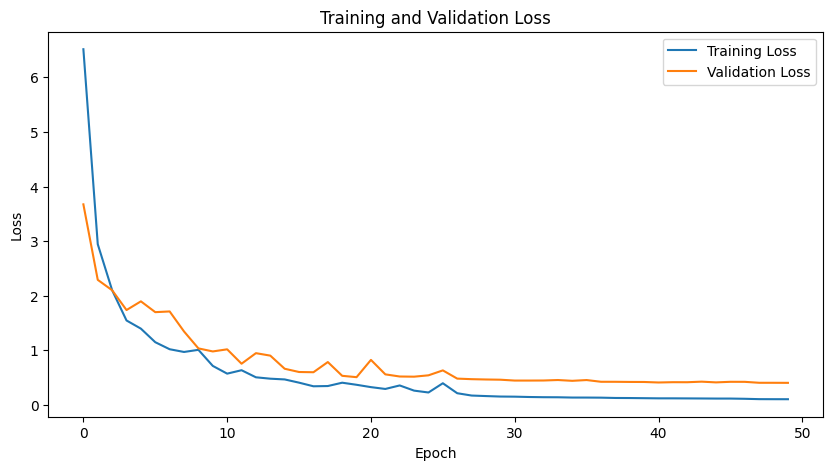

In [ ]:
#Commenting the below code as model is trained separately with 50 epochs and stored in the drive!
#takes an hour.

# interaction = 'dot'
# max_epochs = 50
# batch_size = 32

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# # device = torch.device("cpu")

# train_dataset = Dataclass_CiginV2(train_df)
# valid_dataset = Dataclass_CiginV2(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_CiginV2, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_CiginV2, batch_size=128)
# model = CIGINModel_add31(interaction=interaction)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_CiginV2(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)

# # saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_additional31.tar")

#### RESULTS OF REMOVING A FC LAYER


In [ ]:
loaded_model = CIGINModel_add31().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_additional31.tar'))
loaded_model.eval()
test_dataset = Dataclass_CiginV2(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_CiginV2, batch_size=128)
loss, mae_loss = get_metrics_CiginV2(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Loss :  0.3397056 
Mean Absolute Error Loss:  0.34703332 
Root Mean Square Error:  0.58284265


The above model of additional experiment 3.2 resulted in a RMSE of 0.5828 kcal/mol.

### Additional Experiment 3.2 : ADDING A FC LAYER

In [ ]:
class CIGINModel_add32(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                 node_input_dim=42,
                 edge_input_dim=10,
                 node_hidden_dim=42,
                 edge_hidden_dim=42,
                 num_step_message_passing=6,
                 interaction='dot',
                 num_step_set2_set=2,
                 num_layer_set2set=1,
                 ):
        super(CIGINModel_add32, self).__init__()

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction
        self.solute_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                         self.node_hidden_dim, self.edge_input_dim,
                                         self.num_step_message_passing,
                                         )
        self.solvent_gather = GatherModel(self.node_input_dim, self.edge_input_dim,
                                          self.node_hidden_dim, self.edge_input_dim,
                                          self.num_step_message_passing,
                                          )

        self.fc1 = nn.Linear(8 * self.node_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc22 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.imap = nn.Linear(80, 1) #keep unchanged

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set_solute = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)
        self.set2set_solvent = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

    def forward(self, data):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.solute_gather(solute, solute.ndata['x'].float(), solute.edata['w'].float())
        try:
            # if edge exists in a molecule
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), solvent.edata['w'].float())
        except:
            # if edge doesn't exist in a molecule, for example in case of water
            solvent_features = self.solvent_gather(solvent, solvent.ndata['x'].float(), None)

        # Interaction phase
        len_map = torch.mm(solute_len.t(), solvent_len)

        if 'dot' not in self.interaction:
            X1 = solute_features.unsqueeze(0)
            Y1 = solvent_features.unsqueeze(1)
            X2 = X1.repeat(solvent_features.shape[0], 1, 1)
            Y2 = Y1.repeat(1, solute_features.shape[0], 1)
            Z = torch.cat([X2, Y2], -1)

            if self.interaction == 'general':
                interaction_map = self.imap(Z).squeeze(2)
            if self.interaction == 'tanh-general':
                interaction_map = torch.tanh(self.imap(Z)).squeeze(2)

            interaction_map = torch.mul(len_map.float(), interaction_map.t())
            ret_interaction_map = torch.clone(interaction_map)

        elif 'dot' in self.interaction:
            interaction_map = torch.mm(solute_features, solvent_features.t())
            if 'scaled' in self.interaction:
                interaction_map = interaction_map / (np.sqrt(self.node_hidden_dim))

            ret_interaction_map = torch.clone(interaction_map)
            ret_interaction_map = torch.mul(len_map.float(), ret_interaction_map)
            interaction_map = torch.tanh(interaction_map)
            interaction_map = torch.mul(len_map.float(), interaction_map)

        solvent_prime = torch.mm(interaction_map.t(), solute_features)
        solute_prime = torch.mm(interaction_map, solvent_features)

        # Prediction phase
        solute_features = torch.cat((solute_features, solute_prime), dim=1)
        solvent_features = torch.cat((solvent_features, solvent_prime), dim=1)

        solute_features = self.set2set_solute(solute, solute_features)
        solvent_features = self.set2set_solvent(solvent, solvent_features)

        final_features = torch.cat((solute_features, solvent_features), 1)
        predictions = torch.relu(self.fc1(final_features))
        predictions = torch.relu(self.fc2(predictions))
        predictions = torch.relu(self.fc22(predictions))
        predictions = self.fc3(predictions)

        return predictions, ret_interaction_map

#### TRAINING

100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Epoch: 1  train_loss 8.540536 Val_loss 4.698228 MAE Val_loss 1.44837


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 2  train_loss 4.5895424 Val_loss 5.360559 MAE Val_loss 1.6936831


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch: 3  train_loss 3.8119159 Val_loss 3.4491093 MAE Val_loss 1.293087


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch: 4  train_loss 2.7104867 Val_loss 2.8194573 MAE Val_loss 1.2152915


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch: 5  train_loss 2.1847477 Val_loss 2.290985 MAE Val_loss 1.1137226


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Epoch: 6  train_loss 1.5910046 Val_loss 1.6771226 MAE Val_loss 0.985713


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


Epoch: 7  train_loss 1.2978413 Val_loss 2.0488226 MAE Val_loss 1.0960228


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch: 8  train_loss 1.2470063 Val_loss 1.6277292 MAE Val_loss 0.91838765


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch: 9  train_loss 1.2815614 Val_loss 1.2032459 MAE Val_loss 0.7655027


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 10  train_loss 0.8312608 Val_loss 0.98269427 MAE Val_loss 0.70577145


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 11  train_loss 0.7440673 Val_loss 0.95503247 MAE Val_loss 0.71933067


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Epoch: 12  train_loss 0.65442187 Val_loss 0.8101132 MAE Val_loss 0.6390337


100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Epoch: 13  train_loss 0.66463107 Val_loss 0.8681533 MAE Val_loss 0.6714884


100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch: 14  train_loss 0.7695244 Val_loss 0.76999426 MAE Val_loss 0.5931699


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 15  train_loss 0.6355155 Val_loss 0.870186 MAE Val_loss 0.6530887


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 16  train_loss 0.55488765 Val_loss 1.0775999 MAE Val_loss 0.77896357


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Epoch: 17  train_loss 0.5682922 Val_loss 0.81795263 MAE Val_loss 0.69114816


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Epoch: 18  train_loss 0.5209725 Val_loss 0.5518186 MAE Val_loss 0.49574977


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


Epoch: 19  train_loss 0.37074664 Val_loss 0.50313467 MAE Val_loss 0.49278677


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 20  train_loss 0.368078 Val_loss 0.6092832 MAE Val_loss 0.5419995


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch: 21  train_loss 0.3864732 Val_loss 0.7081078 MAE Val_loss 0.5455796


100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


Epoch: 22  train_loss 0.3050485 Val_loss 0.49074838 MAE Val_loss 0.46266067


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Epoch: 23  train_loss 0.31053475 Val_loss 0.6752693 MAE Val_loss 0.55935717


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Epoch: 24  train_loss 0.27116355 Val_loss 0.45626196 MAE Val_loss 0.4441902


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Epoch: 25  train_loss 0.2804599 Val_loss 0.44207013 MAE Val_loss 0.44358936


100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Epoch: 26  train_loss 0.22561885 Val_loss 0.44880873 MAE Val_loss 0.4271152


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


Epoch: 27  train_loss 0.24117616 Val_loss 0.4497073 MAE Val_loss 0.4741414


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 28  train_loss 0.23204173 Val_loss 0.42518148 MAE Val_loss 0.41877732


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 29  train_loss 0.25643817 Val_loss 0.5227322 MAE Val_loss 0.5112531


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 30  train_loss 0.27561408 Val_loss 0.5377321 MAE Val_loss 0.47565994


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 31  train_loss 0.24346656 Val_loss 0.7009897 MAE Val_loss 0.61043537


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Epoch: 32  train_loss 0.25145125 Val_loss 0.43294978 MAE Val_loss 0.43194517


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch: 33  train_loss 0.19052975 Val_loss 0.50884163 MAE Val_loss 0.45502424


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch: 34  train_loss 0.1967892 Val_loss 0.39755502 MAE Val_loss 0.39766902


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 35  train_loss 0.18773906 Val_loss 0.47128302 MAE Val_loss 0.44148725


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Epoch: 36  train_loss 0.16563381 Val_loss 0.45067734 MAE Val_loss 0.44625163


100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


Epoch: 37  train_loss 0.20239983 Val_loss 0.7832061 MAE Val_loss 0.51532584


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch: 38  train_loss 0.22676265 Val_loss 0.3920926 MAE Val_loss 0.402288


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 39  train_loss 0.19351196 Val_loss 0.5479969 MAE Val_loss 0.47982293


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Epoch: 40  train_loss 0.1718529 Val_loss 0.47283474 MAE Val_loss 0.42535174


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Epoch: 41  train_loss 0.19495037 Val_loss 0.35426632 MAE Val_loss 0.39413172


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 42  train_loss 0.1715917 Val_loss 0.38482207 MAE Val_loss 0.39307433


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Epoch: 43  train_loss 0.13588971 Val_loss 0.3687369 MAE Val_loss 0.38279593


100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


Epoch: 44  train_loss 0.119579665 Val_loss 0.44826403 MAE Val_loss 0.4018335


100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Epoch: 45  train_loss 0.1267633 Val_loss 0.33689678 MAE Val_loss 0.3800771


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 46  train_loss 0.10619641 Val_loss 0.40047348 MAE Val_loss 0.41327918


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Epoch: 47  train_loss 0.10193964 Val_loss 0.43192932 MAE Val_loss 0.43377095


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch: 48  train_loss 0.15484676 Val_loss 0.3684247 MAE Val_loss 0.38799283


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Epoch: 49  train_loss 0.17421746 Val_loss 0.60162103 MAE Val_loss 0.61035836


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Epoch: 50  train_loss 0.20106308 Val_loss 0.6949738 MAE Val_loss 0.53264225


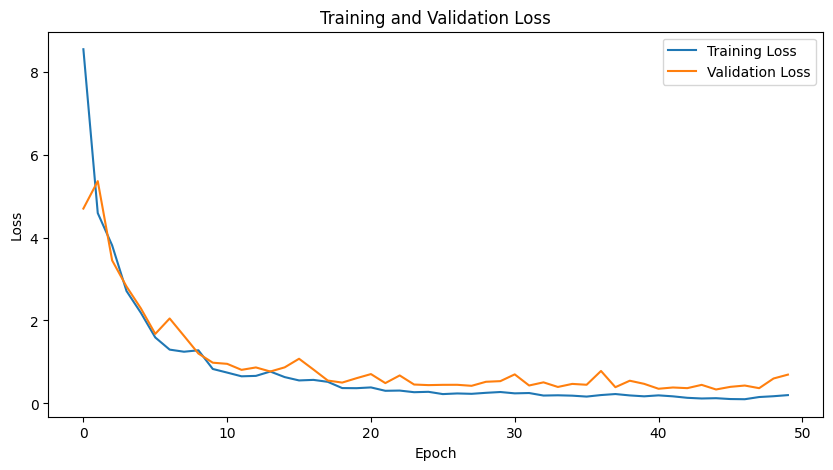

In [ ]:
#Commenting the below code as model is trained separately with 50 epochs and stored in the drive!
#takes an hour.

# interaction = 'dot'
# max_epochs = 50
# batch_size = 32

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# # device = torch.device("cpu")

# train_dataset = Dataclass_CiginV2(train_df)
# valid_dataset = Dataclass_CiginV2(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_CiginV2, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_CiginV2, batch_size=128)
# model = CIGINModel_add32(interaction=interaction)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_CiginV2(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


##Saving the best model to drive ! Commenting the below line as best model is already saved to the drive!
## torch.save(best_model,raw_data_dir + "best_model_additional32.tar")

#### RESULTS


In [ ]:
loaded_model = CIGINModel_add32().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_additional32.tar'))
loaded_model.eval()
test_dataset = Dataclass_CiginV2(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_CiginV2, batch_size=128)
loss, mae_loss = get_metrics_CiginV2(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Loss :  0.55283463 
Mean Absolute Error Loss:  0.480205 
Root Mean Square Error:  0.7435285


The above model of additional experiment 3.2 resulted in an RMSE of 0.7435 kcal/mol.

### Discussion

Both adding and removing a fully connected layer worsened performance of the model compared to the original model. Adding a layer interestingly worsened performance far more than removing one, increasing RMSE to .74, while removing one only impacted performance to the extent of increasing it to .58.

It seems as though the number of fully connected layers is either near optimal or could be reduced in the case of this improved version of CIGIN.

# ABLATIONS

## ABLATION 1 : Variant of Readout Layer (Sum Pooling)
Modifying a phase in our main model

In [ ]:
#CIGIN Variant 2 modification : (sum pooling layers in both the message passing and prediction phase)

device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin_abl1(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin_abl1, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.first_layer = nn.Linear(4*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.third_layer = nn.Linear(200,120)
        self.fourth_layer = nn.Linear(120,1)

    def sumpooling(self,tensor,no_of_features):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        return tensor.sum(dim=1)

    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph_Cigin(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        sumpooling_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.sumpooling(sumpooling_input_solute,self.node_dim) #A

        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph_Cigin(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        sumpooling_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.sumpooling(sumpooling_input_solvent,self.node_dim) #B
        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)
        interaction_map_2 = torch.zeros(n,m)

        for i,solute_row in enumerate(gather_solute):
            for j,solvent_row in enumerate(gather_solvent):
                interaction_map[i, j] = torch.sum(torch.mul(solute_row, solvent_row))
                interaction_map_2[i, j] = torch.sum(torch.mul(solute_row, solvent_row))


        interaction_map_2 = torch.tanh(interaction_map_2) #I


        solute_after_interaction = torch.mm(interaction_map_2, gather_solvent) #A'
        solvent_after_interaction = torch.mm(interaction_map_2.t(), gather_solute) #B'
        #Prediction phase
        combined_features_solute_features = self.sumpooling(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features) #A''
        combined_features_solvent_features = self.sumpooling(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()

In [ ]:
#Commenting the below code as model is trained separately with 50 epochs and stored in the drive!
#takes an hour.

# max_epochs = 50
# batch_size = 1

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_Cigin(train_df)
# valid_dataset = Dataclass_Cigin(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_Cigin, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_Cigin, batch_size=1)
# model = Cigin_abl1()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)

# ## saving the best model to the drive!  Commenting as we have already saved the best model!
# torch.save(best_model,raw_data_dir + "best_model_ablation_sum_pool.tar")

### RESULTS

In [ ]:
loaded_model = Cigin_abl1().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_ablation_sum_pool.tar'))
loaded_model.eval()
test_dataset = Dataclass_Cigin(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_Cigin, batch_size=1)
loss, mae_loss = get_metrics_Cigin(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 233/233 [00:06<00:00, 33.65it/s]


Loss :  0.6053439 
Mean Absolute Error Loss:  0.47979298 
Root Mean Square Error:  0.7780385


The above model of ablation study 1 resulted in a RMSE of 0.778 kcal/mol.

###DISCUSSION

Sum Pooling clearly performed significantly worse than Seq2Seq when used as a pooling layer, likely due to the lack of complexity of the approach and the inability to adjust to features of the problem space, as discussed in the additional experiments section as well.

## ABLATION 2 - Baseline Model (Removing a phase from our main model)

The authors of the paper have reported that variant 2 of baseline CIGIN gave the best results. In this ablation we test the baseline CIGIN model which concatenates the solute and solvent outputs from the gather layer without the explicit use of interaction phase. As the authors stated in the paper, this experiment highlights the significance of the interaction phase introduced in the paper as improvement to the baseline CIGIN model.

In [ ]:
#CIGIN Baseline model without the interaction phase!

device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin_Baseline(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin_Baseline, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.lstm_solute = torch.nn.LSTM(2*self.node_dim,self.node_dim)
        self.lstm_solvent = torch.nn.LSTM(2*self.node_dim,self.node_dim)

        self.lstm_gather_solute = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)
        self.lstm_gather_solvent = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)

        self.first_layer = nn.Linear(16*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.third_layer = nn.Linear(200,120)
        self.fourth_layer = nn.Linear(120,1)

    def set2set(self,tensor,no_of_features,no_of_steps,lstm):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        n = tensor.shape[0]
        tensor=tensor.transpose(0,1)
        q_star = torch.zeros(n,2*no_of_features).to(device)
        hidden = (torch.zeros(1, n, no_of_features).to(device),
              torch.zeros(1, n, no_of_features).to(device))
        for i in range(no_of_steps):
            q,hidden = lstm(q_star.unsqueeze(0),hidden)
            e = torch.sum(tensor*q,2)
            a = F.softmax(e,dim=0)
            r = a.unsqueeze(2)*tensor
            r=  torch.sum(r,0)
            q_star = torch.cat([q.squeeze(0),r],1)
        return q_star


    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph_Cigin(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        set2set_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.set2set(set2set_input_solute,self.node_dim,self.LSTM_t,self.lstm_solute) #A


        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph_Cigin(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        set2set_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.set2set(set2set_input_solvent,self.node_dim,self.LSTM_t,self.lstm_solvent) #B

        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)

        ##Removing the interaction phase and concatenating the results from above above phase for prediction!

        #Prediction phase
        solute_after_interaction = torch.zeros_like(gather_solute) #A'
        solvent_after_interaction = torch.zeros_like(gather_solvent) #B'
        combined_features_solute_features = self.set2set(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features,2,self.lstm_gather_solute) #A''
        combined_features_solvent_features = self.set2set(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features,2,self.lstm_gather_solvent) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()

### TRAINING


In [ ]:
# Commenting the below code as the model is trained separately with 50 epochs and stored in the drive!

# max_epochs = 50
# batch_size = 1

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_Cigin(train_df)
# valid_dataset = Dataclass_Cigin(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_Cigin, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_Cigin, batch_size=1)
# model = Cigin_Baseline()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)

##saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_ablation2.tar")

### RESULTS

In [ ]:
loaded_model = Cigin_Baseline().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_ablation2.tar'))
loaded_model.eval()
test_dataset = Dataclass_Cigin(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_Cigin, batch_size=1)
loss, mae_loss = get_metrics_Cigin(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 233/233 [00:04<00:00, 53.36it/s]


Loss :  0.5693924 
Mean Absolute Error Loss:  0.42911786 
Root Mean Square Error:  0.7545809


The above model resulted in a RMSE of 0.75 kcal/mol. The reported RMSE score of baseline CIGIN model is 0.65 kcal/mol.

### Discussion

The interaction phase in the original model is meant to capture how solute - solvent features interact, as solubility is a function of the specific solute - solvent combination. Naturally speaking, then, the exclusion of an interaction phase where features can combine based on a function would negatively impact performance, as seen above.

## ABLATION 3 : Addition and Removal of Fully Connected Layer in CIGIN Variant 2 (our main model).

<b> CIGIN Variant 2: </b><br>
This experiment, tries to modify the architecture of this CIGIN Variant 2 (set2set layers in two phases), to determine if the changes we try are better than the variant 2 of CIGIN model that the authors proposed in the paper. The variant 2 of the CIGIN model is the main model we implemented in the main experiment section, to prove the hypothesis claimed in the paper. <br>

In the following experiment, we try two model modifications:
* Ablation 3.1 : Add a fully connected layer to the CIGIN Variant 2.
* Ablation 3.2 : Remove a fully connected layer from the CIGIN Variant 2.



### ABLATION 3.1 : ADDITION OF FULLY CONNECTED LAYER TO CIGIN VARIANT 2 (Our main model)

In [ ]:
#Adding Fully Connected layer to CIGIN Variant 2 (Best model reported in the paper).
device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin_abl31(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin_abl31, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.lstm_solute = torch.nn.LSTM(2*self.node_dim,self.node_dim)
        self.lstm_solvent = torch.nn.LSTM(2*self.node_dim,self.node_dim)

        self.lstm_gather_solute = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)
        self.lstm_gather_solvent = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)

        self.first_layer = nn.Linear(16*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.second_and_half_layer = nn.Linear(200,150)
        self.third_layer = nn.Linear(150,120)
        self.fourth_layer = nn.Linear(120,1)

    def set2set(self,tensor,no_of_features,no_of_steps,lstm):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        n = tensor.shape[0]
        tensor=tensor.transpose(0,1)
        q_star = torch.zeros(n,2*no_of_features).to(device)
        hidden = (torch.zeros(1, n, no_of_features).to(device),
              torch.zeros(1, n, no_of_features).to(device))
        for i in range(no_of_steps):
            q,hidden = lstm(q_star.unsqueeze(0),hidden)
            e = torch.sum(tensor*q,2)
            a = F.softmax(e,dim=0)
            r = a.unsqueeze(2)*tensor
            r=  torch.sum(r,0)
            q_star = torch.cat([q.squeeze(0),r],1)
        return q_star


    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph_Cigin(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        set2set_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.set2set(set2set_input_solute,self.node_dim,self.LSTM_t,self.lstm_solute) #A


        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph_Cigin(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        set2set_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.set2set(set2set_input_solvent,self.node_dim,self.LSTM_t,self.lstm_solvent) #B

        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)
        interaction_map_2 = torch.zeros(n,m)

        for i,solute_row in enumerate(gather_solute):
            for j,solvent_row in enumerate(gather_solvent):
                interaction_map[i, j] = torch.sum(torch.mul(solute_row, solvent_row))
                interaction_map_2[i, j] = torch.sum(torch.mul(solute_row, solvent_row))


        interaction_map_2 = torch.tanh(interaction_map_2) #I


        solute_after_interaction = torch.mm(interaction_map_2, gather_solvent) #A'
        solvent_after_interaction = torch.mm(interaction_map_2.t(), gather_solute) #B'

        #Prediction phase
        combined_features_solute_features = self.set2set(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features,2,self.lstm_gather_solute) #A''
        combined_features_solvent_features = self.set2set(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features,2,self.lstm_gather_solvent) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        combined_features = F.relu(self.second_and_half_layer(combined_features))
        combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()

#### TRAINING


100%|██████████| 233/233 [00:05<00:00, 45.45it/s]


Epoch: 1  train_loss 5.2341285 Val_loss 3.0590935 MAE Val_loss 1.2056625


100%|██████████| 233/233 [00:05<00:00, 44.22it/s]


Epoch: 2  train_loss 3.0843337 Val_loss 3.7533402 MAE Val_loss 1.1952397


100%|██████████| 233/233 [00:05<00:00, 39.67it/s]


Epoch: 3  train_loss 2.373964 Val_loss 2.9270954 MAE Val_loss 1.3762861


100%|██████████| 233/233 [00:05<00:00, 41.05it/s]


Epoch: 4  train_loss 1.7792622 Val_loss 1.5576745 MAE Val_loss 0.8455114


100%|██████████| 233/233 [00:05<00:00, 42.28it/s]


Epoch: 5  train_loss 1.783693 Val_loss 2.3014414 MAE Val_loss 0.97965455


100%|██████████| 233/233 [00:05<00:00, 40.71it/s]


Epoch: 6  train_loss 1.2693714 Val_loss 2.2110085 MAE Val_loss 1.1025364


100%|██████████| 233/233 [00:04<00:00, 46.73it/s]


Epoch: 7  train_loss 1.1792792 Val_loss 1.0146232 MAE Val_loss 0.65820825


100%|██████████| 233/233 [00:05<00:00, 40.87it/s]


Epoch: 8  train_loss 0.9572602 Val_loss 1.6146562 MAE Val_loss 0.8836581


100%|██████████| 233/233 [00:05<00:00, 46.35it/s]


Epoch: 9  train_loss 0.9150018 Val_loss 0.89615494 MAE Val_loss 0.5895971


100%|██████████| 233/233 [00:04<00:00, 46.72it/s]


Epoch: 10  train_loss 0.9580655 Val_loss 1.0116215 MAE Val_loss 0.705895


100%|██████████| 233/233 [00:05<00:00, 42.41it/s]


Epoch: 11  train_loss 0.7964629 Val_loss 1.8175458 MAE Val_loss 1.0058792


100%|██████████| 233/233 [00:05<00:00, 41.17it/s]


Epoch: 12  train_loss 1.5746043 Val_loss 0.93769985 MAE Val_loss 0.6099874


100%|██████████| 233/233 [00:05<00:00, 45.91it/s]


Epoch: 13  train_loss 0.63462526 Val_loss 0.86923885 MAE Val_loss 0.57495606


100%|██████████| 233/233 [00:04<00:00, 46.87it/s]


Epoch: 14  train_loss 0.6726129 Val_loss 0.96791047 MAE Val_loss 0.7053648


100%|██████████| 233/233 [00:05<00:00, 46.39it/s]


Epoch: 15  train_loss 0.59038436 Val_loss 0.73509353 MAE Val_loss 0.5462485


100%|██████████| 233/233 [00:05<00:00, 42.14it/s]


Epoch: 16  train_loss 0.5156318 Val_loss 0.77373767 MAE Val_loss 0.5502779


100%|██████████| 233/233 [00:05<00:00, 41.21it/s]


Epoch: 17  train_loss 0.50541264 Val_loss 0.8104189 MAE Val_loss 0.54028577


100%|██████████| 233/233 [00:04<00:00, 47.27it/s]


Epoch: 18  train_loss 0.53682274 Val_loss 0.68115485 MAE Val_loss 0.5592156


100%|██████████| 233/233 [00:04<00:00, 47.06it/s]


Epoch: 19  train_loss 0.5053755 Val_loss 3.955539 MAE Val_loss 1.4643304


100%|██████████| 233/233 [00:05<00:00, 41.30it/s]


Epoch: 20  train_loss 0.5223978 Val_loss 0.70980823 MAE Val_loss 0.54253966


100%|██████████| 233/233 [00:05<00:00, 43.95it/s]


Epoch: 21  train_loss 0.41115668 Val_loss 1.4640361 MAE Val_loss 0.8872986


100%|██████████| 233/233 [00:04<00:00, 46.95it/s]


Epoch: 22  train_loss 0.40663958 Val_loss 0.8532383 MAE Val_loss 0.6642702


100%|██████████| 233/233 [00:05<00:00, 42.06it/s]


Epoch: 23  train_loss 0.40717262 Val_loss 1.4595433 MAE Val_loss 0.8473464


100%|██████████| 233/233 [00:05<00:00, 41.59it/s]


Epoch: 24  train_loss 0.39521456 Val_loss 0.6661144 MAE Val_loss 0.4692392


100%|██████████| 233/233 [00:05<00:00, 40.06it/s]


Epoch: 25  train_loss 0.36521727 Val_loss 0.683431 MAE Val_loss 0.5065078


100%|██████████| 233/233 [00:05<00:00, 41.29it/s]


Epoch: 26  train_loss 0.34888625 Val_loss 0.64175147 MAE Val_loss 0.5239219


100%|██████████| 233/233 [00:05<00:00, 40.72it/s]


Epoch: 27  train_loss 0.8135997 Val_loss 0.85267764 MAE Val_loss 0.607274


100%|██████████| 233/233 [00:05<00:00, 45.82it/s]


Epoch: 28  train_loss 0.33915085 Val_loss 0.49991867 MAE Val_loss 0.45597467


100%|██████████| 233/233 [00:05<00:00, 45.10it/s]


Epoch: 29  train_loss 0.3003445 Val_loss 0.511968 MAE Val_loss 0.43092614


100%|██████████| 233/233 [00:05<00:00, 40.29it/s]


Epoch: 30  train_loss 0.33398572 Val_loss 0.8161294 MAE Val_loss 0.70044076


100%|██████████| 233/233 [00:05<00:00, 40.81it/s]


Epoch: 31  train_loss 0.28067458 Val_loss 0.6182479 MAE Val_loss 0.49482763


100%|██████████| 233/233 [00:05<00:00, 40.64it/s]


Epoch: 32  train_loss 0.32356158 Val_loss 0.5780186 MAE Val_loss 0.47988707


100%|██████████| 233/233 [00:05<00:00, 40.09it/s]


Epoch: 33  train_loss 0.27080345 Val_loss 0.72237444 MAE Val_loss 0.5444419


100%|██████████| 233/233 [00:05<00:00, 40.34it/s]


Epoch: 34  train_loss 0.290325 Val_loss 0.5651827 MAE Val_loss 0.50171447


100%|██████████| 233/233 [00:05<00:00, 45.66it/s]


Epoch: 35  train_loss 0.13479333 Val_loss 0.47667122 MAE Val_loss 0.39331862


100%|██████████| 233/233 [00:05<00:00, 41.02it/s]


Epoch: 36  train_loss 0.10962961 Val_loss 0.47097898 MAE Val_loss 0.38738942


100%|██████████| 233/233 [00:05<00:00, 42.97it/s]


Epoch: 37  train_loss 0.09713411 Val_loss 0.4744018 MAE Val_loss 0.38702422


100%|██████████| 233/233 [00:05<00:00, 38.92it/s]


Epoch: 38  train_loss 0.08784436 Val_loss 0.51171535 MAE Val_loss 0.415873


100%|██████████| 233/233 [00:05<00:00, 41.68it/s]


Epoch: 39  train_loss 0.08474156 Val_loss 0.4921792 MAE Val_loss 0.4027571


100%|██████████| 233/233 [00:05<00:00, 43.69it/s]


Epoch: 40  train_loss 0.08151199 Val_loss 0.4971938 MAE Val_loss 0.41442052


100%|██████████| 233/233 [00:05<00:00, 41.67it/s]


Epoch: 41  train_loss 0.07886288 Val_loss 0.4608738 MAE Val_loss 0.3713854


100%|██████████| 233/233 [00:05<00:00, 40.52it/s]


Epoch: 42  train_loss 0.075143784 Val_loss 0.48474962 MAE Val_loss 0.39264354


100%|██████████| 233/233 [00:05<00:00, 44.99it/s]


Epoch: 43  train_loss 0.07445677 Val_loss 0.46945104 MAE Val_loss 0.37183955


100%|██████████| 233/233 [00:05<00:00, 42.62it/s]


Epoch: 44  train_loss 0.06868392 Val_loss 0.4687853 MAE Val_loss 0.37742975


100%|██████████| 233/233 [00:05<00:00, 46.50it/s]


Epoch: 45  train_loss 0.0704487 Val_loss 0.46239898 MAE Val_loss 0.3691036


100%|██████████| 233/233 [00:05<00:00, 40.34it/s]


Epoch: 46  train_loss 0.06880724 Val_loss 0.45622 MAE Val_loss 0.3676802


100%|██████████| 233/233 [00:05<00:00, 39.11it/s]


Epoch: 47  train_loss 0.069415934 Val_loss 0.4560427 MAE Val_loss 0.37515244


100%|██████████| 233/233 [00:05<00:00, 40.56it/s]


Epoch: 48  train_loss 0.0648124 Val_loss 0.4549326 MAE Val_loss 0.36797258


100%|██████████| 233/233 [00:05<00:00, 44.78it/s]


Epoch: 49  train_loss 0.0638768 Val_loss 0.46662697 MAE Val_loss 0.38046384


100%|██████████| 233/233 [00:05<00:00, 45.88it/s]


Epoch: 50  train_loss 0.06284724 Val_loss 0.45669842 MAE Val_loss 0.3642493


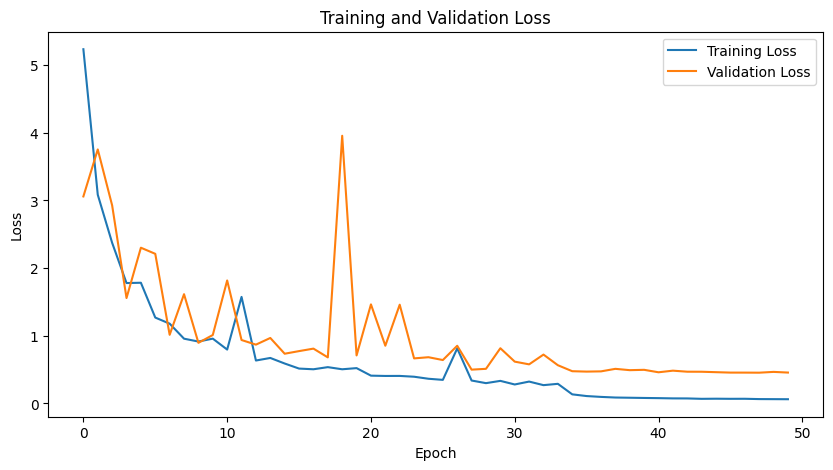

In [ ]:
## Commenting the below code as the model is trained separately with 50 epochs and stored in the drive!

# max_epochs = 50
# batch_size = 1

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

# train_dataset = Dataclass_Cigin(train_df)
# valid_dataset = Dataclass_Cigin(valid_df)
# train_loader = DataLoader(train_dataset, collate_fn=collate_Cigin, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, collate_fn=collate_Cigin, batch_size=1)
# model = Cigin_abl31()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
# best_model = train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)


# saving the best model to the drive!  Commenting as we have already saved the best model!
## torch.save(best_model,raw_data_dir + "best_model_ablation31.tar")

#### RESULTS OF ADDITIONAL EXPERIMENT 3.1:

In [ ]:
loaded_model = Cigin_abl31().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_ablation31.tar'))
loaded_model.eval()
test_dataset = Dataclass_Cigin(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_Cigin, batch_size=128)
loss, mae_loss = get_metrics_Cigin(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:00<00:00, 22.32it/s]


Loss :  0.30832937 
Mean Absolute Error Loss:  0.42941022 
Root Mean Square Error:  0.5552741


The above model of ablation study 3.1 resulted in a RMSE of 0.555 kcal/mol.

### Ablation 3.2 : REMOVAL OF FULLY CONNECTED LAYER TO CIGIN VARIANT 2 (Our main model)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MessagePassing(nn.Module):

    def __init__(self, node_dim, edge_dim,T):
        super(MessagePassing, self).__init__()
        self.node_dim= node_dim
        self.edge_dim = edge_dim

        self.T = T

        self.U_0 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_1 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)
        self.U_2 = nn.Linear(2*self.node_dim + self.edge_dim,self.node_dim)

        self.M_0 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_1 = nn.Linear(2*self.node_dim , self.node_dim)
        self.M_2 = nn.Linear(2*self.node_dim , self.node_dim)


    def message_pass(self,g,h,k):
        message_list = []
        for v in g.keys():
            neighbors = g[v]
            reshaped_list = []
            for neighbor in neighbors:
                e_vw = neighbor[0] # feature variable
                w = neighbor[1]
                reshaped = torch.cat((h[v].view(1,-1), h[w].view(1,-1), e_vw.view(1,-1)), 1)
                if k == 0:
                    reshaped_list.append(self.U_0(reshaped))
                elif k == 1:
                    reshaped_list.append(self.U_1(reshaped))
                elif k == 2:
                    reshaped_list.append(self.U_2(reshaped))
            message_list.append(torch.sum(torch.stack(reshaped_list),0))

        i = 0
        for v in g.keys():
            if k == 0:
                h[v] = F.relu(self.M_0(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 1:
                h[v] = F.relu(self.M_1(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            elif k == 2:
                h[v] = F.relu(self.M_2(torch.cat([h[v].view(1,-1),message_list[i]],1)))
            i += 1

    def forward(self,edge_features, node_features):
        self.edge_features = edge_features
        self.node_features =  node_features
        for k in range(0,self.T):
            self.message_pass(self.edge_features,self.node_features,k)

        return self.edge_features,self.node_features

class ReadoutLayer(nn.Module):
    def __init__(self, node_dim, edge_dim,mem_dim):
        super(ReadoutLayer, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim =  node_dim
        self.mem_dim =  mem_dim
        self.transform_layer = nn.Linear(2*node_dim,2*node_dim)

    def forward(self,v0,v1):

        catted_reads = torch.cat([v0,v1], 1)
        activated_reads = F.relu( self.transform_layer (catted_reads))
        readout = torch.zeros(1, 2*self.node_dim).to(device)

        for read in activated_reads:
            readout = readout + read

        return readout

class Cigin_abl32(nn.Module):
    def __init__(self, node_dim=40, edge_dim=10, T=3):
        super(Cigin_abl32, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.T = T
        self.LSTM_t = 2
        self.solute_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)
        self.solvent_pass = MessagePassing(self.node_dim, self.edge_dim, self.T)

        self.lstm_solute = torch.nn.LSTM(2*self.node_dim,self.node_dim)
        self.lstm_solvent = torch.nn.LSTM(2*self.node_dim,self.node_dim)

        self.lstm_gather_solute = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)
        self.lstm_gather_solvent = torch.nn.LSTM(2*2*2*self.node_dim,2*2*self.node_dim)

        self.first_layer = nn.Linear(16*self.node_dim,360)
        self.second_layer = nn.Linear(360,200)
        self.fourth_layer = nn.Linear(200,1)

    def set2set(self,tensor,no_of_features,no_of_steps,lstm):
        ##### input format ########   no_of_atoms X timesteps X lengthof feature vector
        n = tensor.shape[0]
        tensor=tensor.transpose(0,1)
        q_star = torch.zeros(n,2*no_of_features).to(device)
        hidden = (torch.zeros(1, n, no_of_features).to(device),
              torch.zeros(1, n, no_of_features).to(device))
        for i in range(no_of_steps):
            q,hidden = lstm(q_star.unsqueeze(0),hidden)
            e = torch.sum(tensor*q,2)
            a = F.softmax(e,dim=0)
            r = a.unsqueeze(2)*tensor
            r=  torch.sum(r,0)
            q_star = torch.cat([q.squeeze(0),r],1)
        return q_star


    def forward(self,solute,solvent):

        #Construct molecular graph for solute.
        solute = Chem.MolFromSmiles(solute)
        solute = Chem.AddHs(solute)
        solute = Chem.MolToSmiles(solute)
        edges_solute_0, nodes_solute_0 = ConstructMolecularGraph_Cigin(solute)
        self.edges_solute_0 = deepcopy(edges_solute_0)
        self.nodes_solute_0 =  deepcopy(nodes_solute_0)

        #Message Passing for solute
        self.edges_solute_t, self.nodes_solute_t = self.solute_pass(edges_solute_0,nodes_solute_0)

        #Gather phase for solute
        self.node_features_0 = torch.stack([self.nodes_solute_0[i] for i in self.nodes_solute_0]).reshape(len(self.nodes_solute_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solute_t[i] for i in self.nodes_solute_t]).reshape(len(self.nodes_solute_0),self.node_dim)
        set2set_input_solute = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solute = self.set2set(set2set_input_solute,self.node_dim,self.LSTM_t,self.lstm_solute) #A


        #Construct molecular graph for solute.
        solvent = Chem.MolFromSmiles(solvent)
        solvent = Chem.AddHs(solvent)
        solvent = Chem.MolToSmiles(solvent)
        edges_solvent_0, nodes_solvent_0 = ConstructMolecularGraph_Cigin(solvent)
        self.edges_solvent_0 = deepcopy(edges_solvent_0)
        self.nodes_solvent_0 = deepcopy(nodes_solvent_0)

        #Message passing for solvent
        self.edges_solvent_t, self.nodes_solvent_t = self.solvent_pass(edges_solvent_0,nodes_solvent_0)


        #Gather phase for solvent
        self.node_features_0 = torch.stack([self.nodes_solvent_0[i] for i in self.nodes_solvent_0]).reshape(len(self.nodes_solvent_0),self.node_dim)
        self.node_features_t = torch.stack([self.nodes_solvent_t[i] for i in self.nodes_solvent_t]).reshape(len(self.nodes_solvent_0),self.node_dim)
        set2set_input_solvent = torch.stack([self.node_features_0,self.node_features_t],1)
        gather_solvent = self.set2set(set2set_input_solvent,self.node_dim,self.LSTM_t,self.lstm_solvent) #B

        #Interaction phase

        combined_features_no_of_features=2*self.node_dim
        n = len(self.nodes_solute_t) # no of atoms in solute
        m = len(self.nodes_solvent_t) # no of atoms in solvent

        interaction_map = torch.zeros(n,m)
        interaction_map_2 = torch.zeros(n,m)

        for i,solute_row in enumerate(gather_solute):
            for j,solvent_row in enumerate(gather_solvent):
                interaction_map[i, j] = torch.sum(torch.mul(solute_row, solvent_row))
                interaction_map_2[i, j] = torch.sum(torch.mul(solute_row, solvent_row))


        interaction_map_2 = torch.tanh(interaction_map_2) #I


        solute_after_interaction = torch.mm(interaction_map_2, gather_solvent) #A'
        solvent_after_interaction = torch.mm(interaction_map_2.t(), gather_solute) #B'

        #Prediction phase
        combined_features_solute_features = self.set2set(torch.cat([solute_after_interaction, gather_solute],1).unsqueeze(0),
                                     2*combined_features_no_of_features,2,self.lstm_gather_solute) #A''
        combined_features_solvent_features = self.set2set(torch.cat([solvent_after_interaction, gather_solvent],1).unsqueeze(0),
                                      2*combined_features_no_of_features,2,self.lstm_gather_solvent) #B''

        combined_features = torch.cat([combined_features_solute_features,combined_features_solvent_features], 1)
        combined_features = F.relu(self.first_layer(combined_features))
        combined_features = F.relu(self.second_layer(combined_features))
        # combined_features = F.relu(self.second_and_half_layer(combined_features))
        # combined_features = F.relu(self.third_layer(combined_features))
        combined_features = self.fourth_layer(combined_features)

        return combined_features, interaction_map.detach()

#### TRAINING

100%|██████████| 233/233 [00:05<00:00, 45.26it/s]


Epoch: 1  train_loss 4.67634 Val_loss 2.4487085 MAE Val_loss 1.061782


100%|██████████| 233/233 [00:05<00:00, 43.51it/s]


Epoch: 2  train_loss 2.8156052 Val_loss 1.9864539 MAE Val_loss 0.8860713


100%|██████████| 233/233 [00:05<00:00, 44.18it/s]


Epoch: 3  train_loss 1.7648664 Val_loss 2.5633907 MAE Val_loss 1.2172256


100%|██████████| 233/233 [00:05<00:00, 43.50it/s]


Epoch: 4  train_loss 1.4096874 Val_loss 2.0815625 MAE Val_loss 1.188725


100%|██████████| 233/233 [00:04<00:00, 46.75it/s]


Epoch: 5  train_loss 1.265968 Val_loss 1.0511396 MAE Val_loss 0.64538014


100%|██████████| 233/233 [00:05<00:00, 40.02it/s]


Epoch: 6  train_loss 0.95265025 Val_loss 1.6771526 MAE Val_loss 1.0037518


100%|██████████| 233/233 [00:05<00:00, 41.88it/s]


Epoch: 7  train_loss 0.93945986 Val_loss 0.8352568 MAE Val_loss 0.5759901


100%|██████████| 233/233 [00:06<00:00, 37.55it/s]


Epoch: 8  train_loss 0.8120049 Val_loss 1.1697522 MAE Val_loss 0.73970324


100%|██████████| 233/233 [00:05<00:00, 40.01it/s]


Epoch: 9  train_loss 0.6946895 Val_loss 1.524275 MAE Val_loss 1.0260364


100%|██████████| 233/233 [00:05<00:00, 46.27it/s]


Epoch: 10  train_loss 0.6399897 Val_loss 1.2081021 MAE Val_loss 0.77146524


100%|██████████| 233/233 [00:04<00:00, 47.09it/s]


Epoch: 11  train_loss 0.57392204 Val_loss 1.4590135 MAE Val_loss 0.8912069


100%|██████████| 233/233 [00:05<00:00, 44.10it/s]


Epoch: 12  train_loss 0.5431391 Val_loss 1.2312073 MAE Val_loss 0.85304046


100%|██████████| 233/233 [00:05<00:00, 40.44it/s]


Epoch: 13  train_loss 0.51904714 Val_loss 0.73541987 MAE Val_loss 0.6194741


100%|██████████| 233/233 [00:06<00:00, 38.63it/s]


Epoch: 14  train_loss 0.5801771 Val_loss 1.0147054 MAE Val_loss 0.7086055


100%|██████████| 233/233 [00:05<00:00, 41.81it/s]


Epoch: 15  train_loss 0.47978023 Val_loss 0.6733549 MAE Val_loss 0.5519037


100%|██████████| 233/233 [00:05<00:00, 45.69it/s]


Epoch: 16  train_loss 65.817 Val_loss 0.6864564 MAE Val_loss 0.5457065


100%|██████████| 233/233 [00:05<00:00, 45.44it/s]


Epoch: 17  train_loss 0.34952533 Val_loss 0.5703967 MAE Val_loss 0.46929356


100%|██████████| 233/233 [00:06<00:00, 36.98it/s]


Epoch: 18  train_loss 0.33662552 Val_loss 0.9121915 MAE Val_loss 0.6092536


100%|██████████| 233/233 [00:05<00:00, 40.97it/s]


Epoch: 19  train_loss 0.3389772 Val_loss 0.6725805 MAE Val_loss 0.517698


100%|██████████| 233/233 [00:05<00:00, 45.55it/s]


Epoch: 20  train_loss 0.28796834 Val_loss 0.66190726 MAE Val_loss 0.5181898


100%|██████████| 233/233 [00:05<00:00, 46.59it/s]


Epoch: 21  train_loss 0.36366004 Val_loss 0.61398196 MAE Val_loss 0.47292435


100%|██████████| 233/233 [00:05<00:00, 43.93it/s]


Epoch: 22  train_loss 0.30915776 Val_loss 0.5537712 MAE Val_loss 0.48352262


100%|██████████| 233/233 [00:05<00:00, 41.00it/s]


Epoch: 23  train_loss 0.32441399 Val_loss 0.4831723 MAE Val_loss 0.42167336


100%|██████████| 233/233 [00:05<00:00, 44.29it/s]


Epoch: 24  train_loss 0.33320776 Val_loss 1.0409054 MAE Val_loss 0.682684


100%|██████████| 233/233 [00:05<00:00, 44.54it/s]


Epoch: 25  train_loss 3.874824 Val_loss 0.610977 MAE Val_loss 0.48339888


100%|██████████| 233/233 [00:05<00:00, 40.85it/s]


Epoch: 26  train_loss 0.26963827 Val_loss 0.60738885 MAE Val_loss 0.493882


100%|██████████| 233/233 [00:04<00:00, 47.98it/s]


Epoch: 27  train_loss 0.30684257 Val_loss 0.5911486 MAE Val_loss 0.47535


100%|██████████| 233/233 [00:04<00:00, 47.72it/s]


Epoch: 28  train_loss 0.287886 Val_loss 0.56033075 MAE Val_loss 0.47820383


100%|██████████| 233/233 [00:05<00:00, 45.79it/s]


Epoch: 29  train_loss 0.24837066 Val_loss 0.52432543 MAE Val_loss 0.4340339


100%|██████████| 233/233 [00:04<00:00, 46.86it/s]


Epoch: 30  train_loss 0.14023975 Val_loss 0.45171732 MAE Val_loss 0.39736265


100%|██████████| 233/233 [00:04<00:00, 47.70it/s]


Epoch: 31  train_loss 0.11279237 Val_loss 0.45200026 MAE Val_loss 0.38000873


100%|██████████| 233/233 [00:04<00:00, 47.73it/s]


Epoch: 32  train_loss 0.10371381 Val_loss 0.45491937 MAE Val_loss 0.38122654


100%|██████████| 233/233 [00:05<00:00, 40.75it/s]


Epoch: 33  train_loss 0.09854925 Val_loss 0.4630536 MAE Val_loss 0.39782557


100%|██████████| 233/233 [00:05<00:00, 41.18it/s]


Epoch: 34  train_loss 0.095448956 Val_loss 0.46291676 MAE Val_loss 0.3934062


100%|██████████| 233/233 [00:04<00:00, 47.28it/s]


Epoch: 35  train_loss 0.09142908 Val_loss 0.44614938 MAE Val_loss 0.37357068


100%|██████████| 233/233 [00:05<00:00, 40.83it/s]


Epoch: 36  train_loss 0.08943809 Val_loss 0.45263985 MAE Val_loss 0.38360077


100%|██████████| 233/233 [00:04<00:00, 47.63it/s]


Epoch: 37  train_loss 0.08595358 Val_loss 0.45110357 MAE Val_loss 0.3765202


100%|██████████| 233/233 [00:05<00:00, 42.85it/s]


Epoch: 38  train_loss 0.08476554 Val_loss 0.44287848 MAE Val_loss 0.36828843


100%|██████████| 233/233 [00:05<00:00, 41.97it/s]


Epoch: 39  train_loss 0.082756504 Val_loss 0.44239828 MAE Val_loss 0.36953855


100%|██████████| 233/233 [00:05<00:00, 40.77it/s]


Epoch: 40  train_loss 0.08095088 Val_loss 0.441372 MAE Val_loss 0.37871215


100%|██████████| 233/233 [00:05<00:00, 40.90it/s]


Epoch: 41  train_loss 0.08055466 Val_loss 0.4416466 MAE Val_loss 0.36249733


100%|██████████| 233/233 [00:04<00:00, 47.23it/s]


Epoch: 42  train_loss 0.077044524 Val_loss 0.44108018 MAE Val_loss 0.3659621


100%|██████████| 233/233 [00:05<00:00, 40.20it/s]


Epoch: 43  train_loss 0.07682718 Val_loss 0.44563812 MAE Val_loss 0.36538446


100%|██████████| 233/233 [00:04<00:00, 47.16it/s]


Epoch: 44  train_loss 0.075461745 Val_loss 0.44070607 MAE Val_loss 0.36211357


100%|██████████| 233/233 [00:04<00:00, 47.72it/s]


Epoch: 45  train_loss 0.07414767 Val_loss 0.44288662 MAE Val_loss 0.36327004


100%|██████████| 233/233 [00:05<00:00, 42.34it/s]


Epoch: 46  train_loss 0.07252448 Val_loss 0.432168 MAE Val_loss 0.35849884


100%|██████████| 233/233 [00:05<00:00, 40.65it/s]


Epoch: 47  train_loss 0.07154545 Val_loss 0.44093192 MAE Val_loss 0.37517342


100%|██████████| 233/233 [00:05<00:00, 40.91it/s]


Epoch: 48  train_loss 0.07057421 Val_loss 0.4322781 MAE Val_loss 0.36437756


100%|██████████| 233/233 [00:05<00:00, 40.65it/s]


Epoch: 49  train_loss 0.069398075 Val_loss 0.43001765 MAE Val_loss 0.36037782


100%|██████████| 233/233 [00:05<00:00, 40.62it/s]


Epoch: 50  train_loss 0.06796677 Val_loss 0.4354118 MAE Val_loss 0.36211306


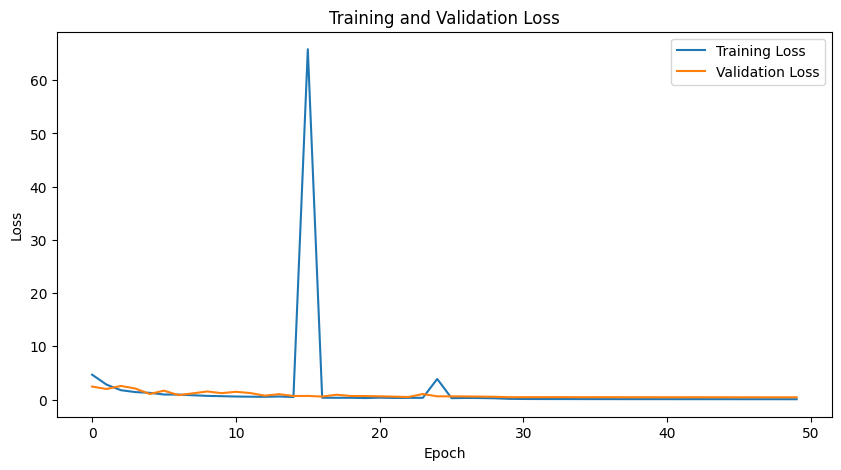

In [ ]:
# Commenting the below code as the model is trained separately with 50 epochs and stored in the drive!

max_epochs = 50
batch_size = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")

train_dataset = Dataclass_Cigin(train_df)
valid_dataset = Dataclass_Cigin(valid_df)
train_loader = DataLoader(train_dataset, collate_fn=collate_Cigin, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, collate_fn=collate_Cigin, batch_size=1)
model = Cigin_abl32()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)
best_model = train_Cigin(max_epochs, model, optimizer, scheduler, train_loader, valid_loader)

## saving the best model to the drive!  Commenting as we have already saved the best model!
torch.save(best_model,raw_data_dir + "best_model_ablation32.tar")

#### RESULTS OF ADDITIONAL EXPERIMENT 3.2

In [ ]:
loaded_model = Cigin_abl32().to(device)
loaded_model.load_state_dict(torch.load(raw_data_dir+'best_model_ablation32.tar'))
loaded_model.eval()
test_dataset = Dataclass_Cigin(test_df)
test_loader = DataLoader(test_dataset, collate_fn=collate_Cigin, batch_size=128)
loss, mae_loss = get_metrics_Cigin(loaded_model, test_loader)
print("\nLoss : ",loss, "\nMean Absolute Error Loss: ", mae_loss, "\nRoot Mean Square Error: ", np.sqrt(loss))

100%|██████████| 2/2 [00:00<00:00, 20.49it/s]


Loss :  1.3943998 
Mean Absolute Error Loss:  0.8957794 
Root Mean Square Error:  1.180847


### Discussion

In this case, the removal of a fully connected layer significantly worsened performance. On the other hand, the addition of a layer did not change it much, and in fact seemed to slightly improve performance. This may indicate that the number of FC layers used in the initial model was insufficient, or that adjusting the number of nodes distributed across layers would improve performance.

# FINAL RESULTS
<b> Consolidating Main Experiment, Experimental Experiments, and Ablation studies.

## MAIN EXPERIMENT RESULTS
| Model              | RMSE  kcal/mol                     |
|--------------------|------------------------------------------|
| Our Trained model     | 0.6046444 |
| Metric reported by the authors in the paper  | 0.57      |
| Metric acquired by the pre-trained model available| 1.4687573   |


We were able to succesfully reproduce the result claimed in the research paper. The reported result was RMSE = 0.57 kcal/mol and we have obtained RMSE of 0.60 kcal/mol on the same dataset.

The result of a pretrained model available in the source github was off compared to the reported results. We suspect this is because a trial model or a different checkpoint model was uploaded in github as reference.

## COMPARING MAIN MODEL WITH ADDITIONAL EXPERIMENTS

| Model              | RMSE kcal/mol                       |
|--------------------|------------------------------------------|
| Our Trained model     | 0.6046444 |
| Metric reported by the authors in the paper  | 0.57      |
| Additional Experiment 1| 0.5202   |
| Additional Experiment 2| 0.5832   |
| Additional Experiment 3.1| 0.5828   |
| Additional Experiment 3.2| 0.7435   |


We have performed 3 additional experiments beyond the research paper.
We see that additional experiment 1, CIGIN version 2, the latest version gave the best results with an RMSE of 0.52 kcal/mol, when compared to main model (baseline CIGIN variant 2) with reported RMSE of 0.57 kcal/mol  and rest of the additional experiments.

## COMPARING MAIN MODEL WITH ABLATIONS

| Model              | RMSE kcal/mol                        |
|--------------------|------------------------------------------|
| Our Trained model      | 0.6046444 |
| Metric reported by the authors in the paper  | 0.57      |
| Ablation Experiment 1| 0.778   |
| Ablation Experiment 2| 0.7546  |
| Ablation Experiment 3.1| 0.5552741   |
| Ablation Experiment 3.2| 1.1808  |

We have conducted 3 additional ablation studies. Out of these experiments, we observe the best model is obtained in ablation study 3.1 where we removed a fully connected layer from the main model (baseline CIGIN variant 2). The model resulted in a RMSE of 0.55 kcal/mol which is lower than the reported RMSE of 0.57 kcal/mol.

However, the newer, unpublished version 2 of CIGIN (additional experiment 1) gave better result of 0.52 kcal/mol. This is the best model amongst all the variants we tried in this project.

# FINAL DISCUSSION

CODE REPRODUCIBILITY:

The source code from git repository referenced in the research paper, is reproducible with minor changes. The obtained results are very close and even better than what is reported in the paper.

EASE OR DIFFICULTY OF REPRODUCIBILITY:

While the code was easy to run with the right environment set up, we had to pre-process the data on our own to convert the publicly available dataset into required format.

Another difficulty we faced with the main model implimentation is the training process. Each sample is trained separately with no scope for batching. This led to very high training time making it time consuming for us to find optimal number of epochs and hyperparameters for the best model.

RECOMMENDATION:

Parallelizing the code and using batching can improve the model training performance and might also add more validation credibility to the results. This is our initial recommendation to the  authors. Later we found another implementation of the CIGIN model in the same github repository, which we implemented as part of out experiments beyond the research paper. In this version 2, the authors have enabled batching and as expected, we have seen better model performance.


# CONCLUSION

We successfully reproduced the approach taken in the paper. What we found as conclusions was the following.

Firstly, the model did perform well in comparison to a baseline due to the inclusion of an interaction phase. In addition, the use of a Seq2Seq layer for collating feature information across graph nodes, versus a naive approach like Sum Pooling, significantly improved performance. On the other hand, several of the linear layers at the end of the model seemed to be unnecessary, based on our ablation studies. In addition, we found that integrating multiple types of layers into the architecture of our message passing network provided a boost to performance as well.

Ultimately, this approach was fairly successful in predicting the solvation free energy for a given solute/solvent pair. This is of great importance to the pharmaceutical industry, assisting in the drug development process by guiding research towards targets with high bioavailability and thus likelihood of being useful.

We recommend investigating more complex MPNN networks as a potential avenue for exploration. Also, integrating knowledge from the literature and more complex interaction patterns and features to build upon this model may also be fruitful directions to work in.



# OUR GITHUB REPOSITORY

https://github.com/sjainer/CIGIN_CS598_data


# REFERENCES

1.   Pathak, Y., Laghuvarapu, S., Mehta, S., & Priyakumar, U. D., [Chemically interpretable graph interaction network for prediction of pharmacokinetic properties of drug-like molecules.], [In Proceedings of the AAAI Conference on Artificial Intelligence], [2020], [Vol. 34]:[No. 01, pp. 873-880], doi: [https://doi.org/10.1609/aaai.v34i01.5433].

